## Imports

In [ ]:
### --- MAIN LIBRARIES --- ###

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

In [ ]:
!pip install geoplot
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
!pip install pyvis


/usr/bin/bash: line 1: apt-get: command not found


In [ ]:
### --- GEO LIBRARIES --- ###

import geopandas as gpd
import geoplot as gplt
import plotly.graph_objects as go
import networkx as nx
import pygraphviz
from pyvis.network import Network

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import cartopy.io.shapereader as shpreader

# Week 1

In [ ]:
os.makedirs('./img', exist_ok=True)

def fig_save(figure, filename) -> None:
    figure.savefig(
        filename,
        dpi=300,
        bbox_inches='tight',
        facecolor='white'
    )

### Part 1

category,geo,EU,Not EU,General
1,DE,4.409114,7.699874,12.108988
2,ES,1.724292,4.777990,6.502282
3,FR,1.576915,4.451597,6.028512
4,IT,1.389640,3.864018,5.253658
0,AT,0.901726,0.883155,1.784881


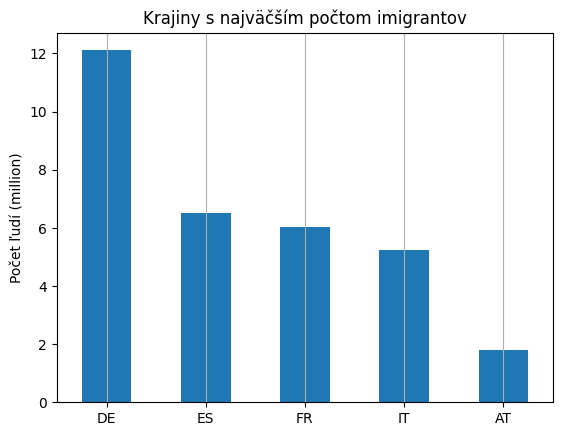

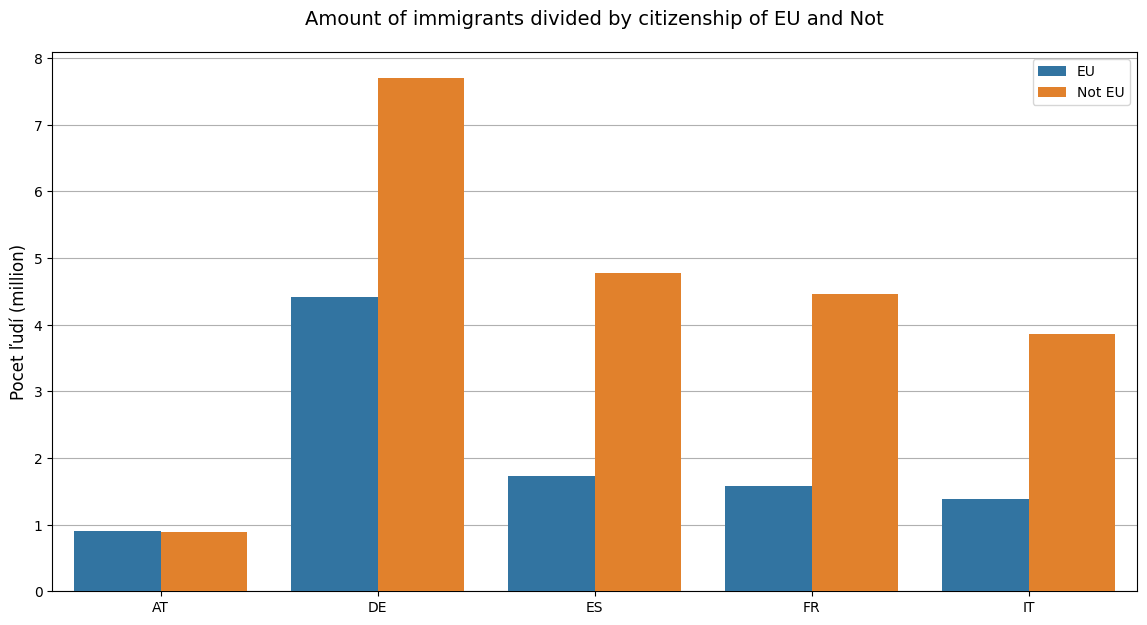

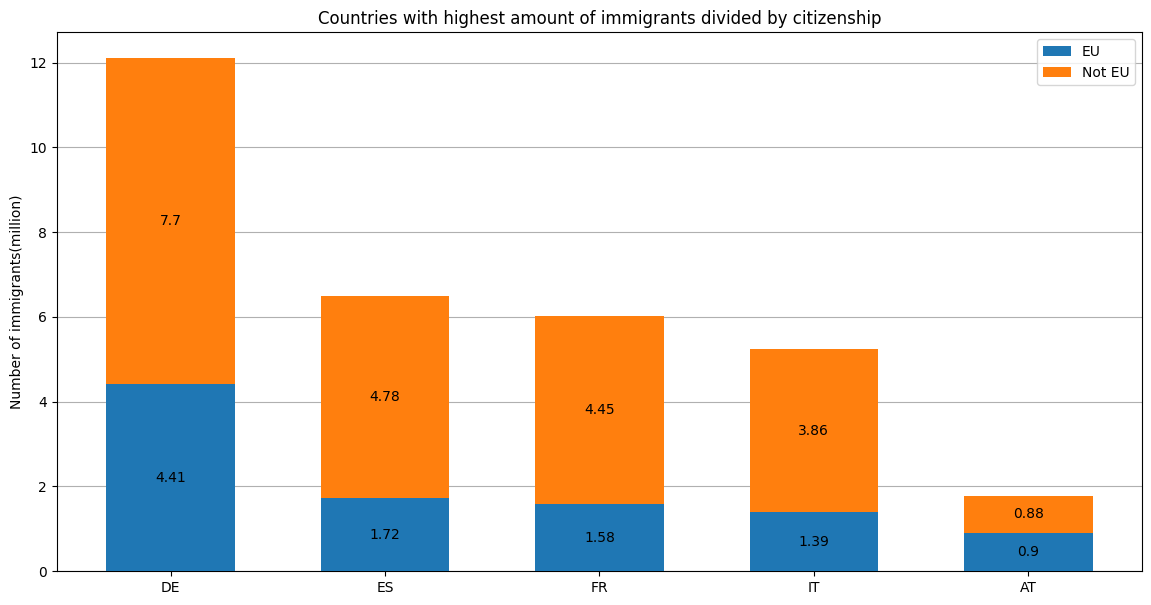

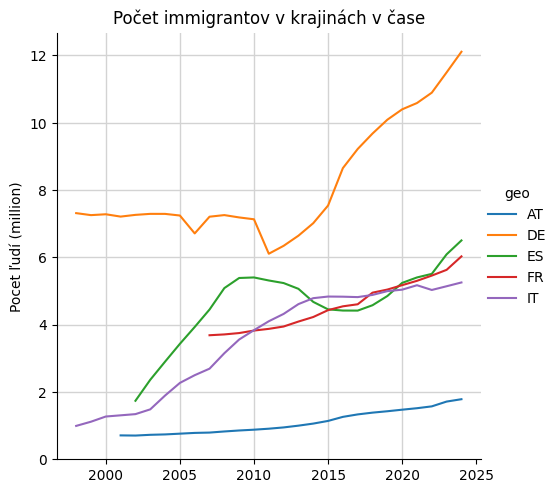

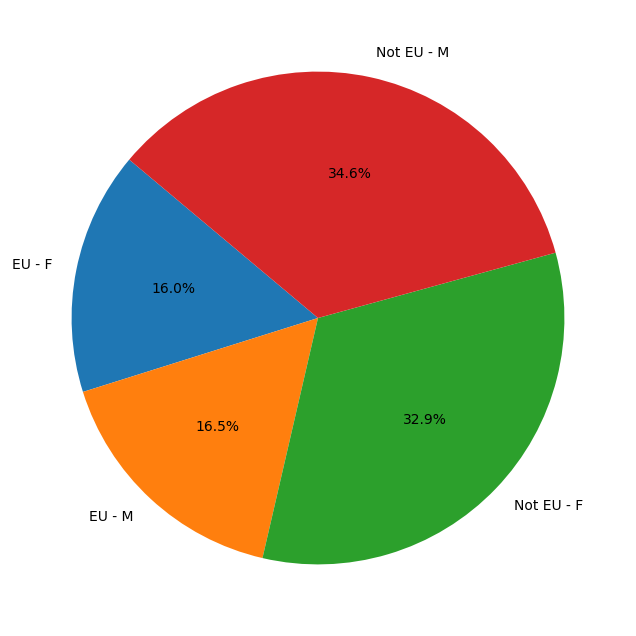

In [ ]:
url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GeneralEU1.csv"
urlEUandNot = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigratesFromEUandNot.csv"
urlEUandNot_and_sex = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigratesFromEUandNot_and_sex.csv"
df = pd.read_csv(url).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq'], axis=1)

# ДатаФрейм без разделения полов
df_without_genders = (df.groupby(['geo', 'TIME_PERIOD'])['OBS_VALUE']
                      .sum()
                      .reset_index()
                      .assign(OBS_VALUE_milion = lambda df: df['OBS_VALUE']/ 1000000))


# ДатаФрейм отсортированный по кол-ву людей по убыванию
df_sorted_by_number_immigrates = df_without_genders[df_without_genders['TIME_PERIOD'] == 2024].sort_values(by="OBS_VALUE", ascending=False)
# Список, который содержит 5 стран с наибольшим кол-вом людей
countries_highest_number_immigrates = list(df_sorted_by_number_immigrates['geo'][:5])
# График людей 5 стран с наибольшим кол-вом людей за 2024 год
plot_for_number_immigrates = df_sorted_by_number_immigrates[:5].plot(x='geo',
                                                                     y='OBS_VALUE_milion',
                                                                     kind='bar',
                                                                     ylabel='Počet ľudí (million)',
                                                                     xlabel='',
                                                                     title='Krajiny s najväčším počtom imigrantov',
                                                                     legend=False)
plot_for_number_immigrates.set_xticklabels(df_sorted_by_number_immigrates[:5]['geo'], rotation=0)
plot_for_number_immigrates.grid(axis='x')

# График людей 5 стран с наибольшим кол-вом людей за 2024 год разделенный по ЕУ и нет
df2 = pd.read_csv(urlEUandNot).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD'], axis=1)
df2['OBS_VALUE_milion'] = df2['OBS_VALUE'] /1000000
df_eu = df2.query('citizen=="EU27_2020_FOR"')
df_total = df2.query('citizen=="FOR_STLS"')
merged = pd.merge(
    df_total[['geo', 'OBS_VALUE_milion']],
    df_eu[['geo', 'OBS_VALUE_milion']],
    on=['geo'],
    suffixes=('_total', '_eu')
)
merged['OBS_VALUE_milion_not_eu'] = merged['OBS_VALUE_milion_total'] - merged['OBS_VALUE_milion_eu']
df_not_eu = merged[['geo', 'OBS_VALUE_milion_not_eu']].rename(columns={'OBS_VALUE_milion_not_eu': 'OBS_VALUE_milion'})
df_eu = df_eu.drop(['citizen', 'age', 'unit', 'sex', 'OBS_VALUE'], axis=1)
df_not_eu['category'] = 'Not EU'
df_eu['category'] = 'EU'
df_not_and_from_eu = pd.concat([df_eu, df_not_eu], ignore_index=True)

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

plot_for_number_immigrates_divided_by_EU = sns.barplot(data=df_not_and_from_eu[df_not_and_from_eu['geo'].isin(countries_highest_number_immigrates)],
                                                       x='geo', y='OBS_VALUE_milion', hue='category', ax=axes, zorder=3)
axes.set_title("Amount of immigrants divided by citizenship of EU and Not", fontsize=14, pad=20)
axes.set_xlabel("", fontsize=12)
axes.set_ylabel("Pocet ľudí (million)", fontsize=12)
axes.legend(title='')
axes.grid(True, axis='y', zorder=0)


#Обьединение первого и второго графиков
df_not_and_from_eu_wide = df_not_and_from_eu[df_not_and_from_eu['geo'].isin(countries_highest_number_immigrates)].pivot(index='geo', columns='category', values='OBS_VALUE_milion').reset_index()
df_not_and_from_eu_wide['General'] = df_not_and_from_eu_wide['EU'] + df_not_and_from_eu_wide['Not EU']
df_not_and_from_eu_wide = df_not_and_from_eu_wide.sort_values(by='General', ascending=False)

display(df_not_and_from_eu_wide)
EU_NOT_counts = {
    'EU': df_not_and_from_eu_wide['EU'],
    'Not EU': df_not_and_from_eu_wide['Not EU'],
}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(df_not_and_from_eu_wide['geo']))

for cship, count in EU_NOT_counts.items():
    p = ax.bar(df_not_and_from_eu_wide['geo'], count, width, label=cship, bottom=bottom, zorder=3)
    bottom += count

    rounded_counts = [str(round(val, 2)) for val in count]
    ax.bar_label(p, labels=rounded_counts, label_type='center')

ax.set_title('Countries with highest amount of immigrants divided by citizenship')
ax.set_ylabel('Number of immigrants(million)')
ax.legend()
ax.grid(True, axis='y', zorder=0)

# График как менялось кол-во людей для 5 стран с наибольшим кол-вом людей за 2024 год
plot_for_number_immigrates_trough_time = sns.relplot(data=df_without_genders[df_without_genders['geo'].isin(countries_highest_number_immigrates)],
                                                     x='TIME_PERIOD', y='OBS_VALUE_milion',
                                                     hue='geo', kind="line", zorder=3)
plot_for_number_immigrates_trough_time.set_axis_labels('', 'Pocet ľudí (million)')
plot_for_number_immigrates_trough_time.set(title='Počet immigrantov v krajinách v čase')
ax = plot_for_number_immigrates_trough_time.axes[0][0]
for i in range(2, 13, 2):
  ax.axhline(y=i, color='lightgray', linewidth=1, zorder=0)
for i in range(2000, 2025, 5):
  ax.axvline(x=i, color='lightgray', linewidth=1, zorder=0)
# Настройка, чтоб отсчет в графике был от нуля
plt.ylim(0, )


df3 = pd.read_csv(urlEUandNot_and_sex).drop(['STRUCTURE','STRUCTURE_ID','STRUCTURE_NAME', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD','Country of citizenship','Age class','Observation value','Observation status (Flag) V2 structure','Confidentiality status (flag)','Time'], axis=1)
df3['OBS_VALUE_milion'] = df3['OBS_VALUE'] / 1_000_000
df3_eu = df3.query('citizen == "EU27_2020_FOR"')
df3_total = df3.query('citizen == "FOR_STLS"')
merged = pd.merge(
    df3_total[['geo', 'sex', 'OBS_VALUE_milion']],
    df3_eu[['geo', 'sex', 'OBS_VALUE_milion']],
    on=['geo', 'sex'],
    suffixes=('_total', '_eu')
)

merged['OBS_VALUE_milion_not_eu'] = merged['OBS_VALUE_milion_total'] - merged['OBS_VALUE_milion_eu']

# non-EU
df3_not_eu = merged[['geo', 'sex', 'OBS_VALUE_milion_not_eu']].rename(columns={'OBS_VALUE_milion_not_eu': 'OBS_VALUE_milion'})
df3_not_eu['category'] = 'Not EU'

# EU (відфільтровуємо лише потрібні колонки)
df3_eu = df3_eu[['geo', 'sex', 'OBS_VALUE_milion']]
df3_eu['category'] = 'EU'
df3_not_and_from_eu = pd.concat([df3_eu, df3_not_eu], ignore_index=True)
df3_not_and_from_eu = df3_not_and_from_eu.sort_values(by='OBS_VALUE_milion')
grouped = df3_not_and_from_eu.groupby(['category', 'sex'])['OBS_VALUE_milion'].sum().reset_index()
grouped['label'] = grouped['category'] + ' - ' + grouped['sex']
plt.figure(figsize=(8, 8))
plt.pie(
    grouped['OBS_VALUE_milion'],
    labels=grouped['label'],
    autopct='%1.1f%%',
    startangle=140
)
plt.show()

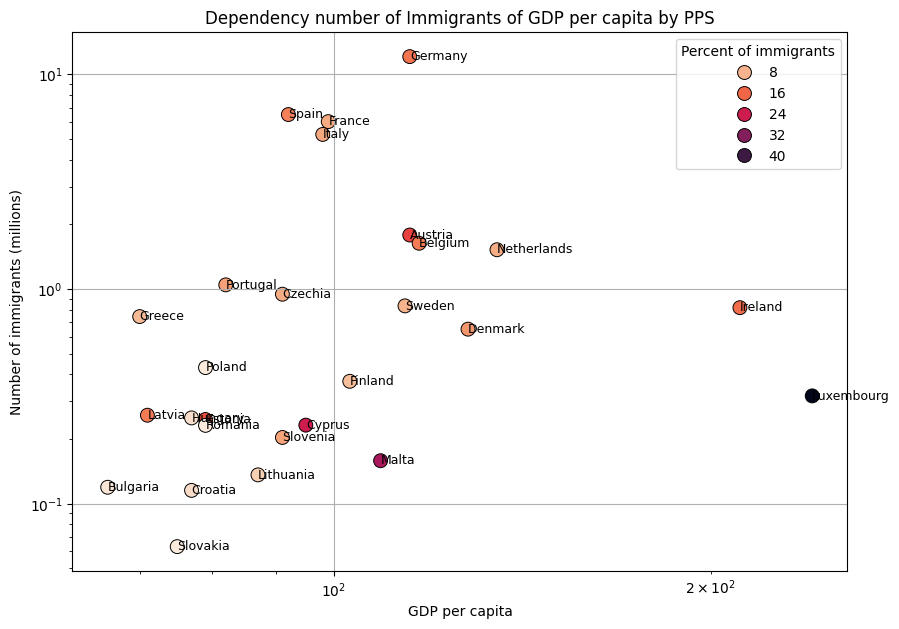

In [ ]:
url_dependency_immigrants_and_GDP = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/GDP_per_capita_in_PPS.csv"
url_for_population = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/population_by_country_of_birth.csv"
df_population_for_sc = pd.read_csv(url_for_population,usecols=['Country/region of birth', 'geo', 'TIME_PERIOD', 'OBS_VALUE']).query(
    'TIME_PERIOD == 2024').query('`Country/region of birth` == "Total"').drop(['Country/region of birth', 'TIME_PERIOD'], axis=1)
df_population_for_sc = df_population_for_sc.rename(columns={'OBS_VALUE': 'Population'})
df_dependency_immigrants_and_GDP = pd.read_csv(url_dependency_immigrants_and_GDP,usecols=['Geopolitical entity (reporting)', 'geo', 'OBS_VALUE'])
df_dependency_immigrants_and_GDP = df_dependency_immigrants_and_GDP.rename(columns={'OBS_VALUE': 'GDP'})
df_dependency_immigrants_and_GDP = pd.merge(df_dependency_immigrants_and_GDP, df_sorted_by_number_immigrates, on='geo').drop(['TIME_PERIOD'], axis=1)
df_dependency_immigrants_and_GDP = pd.merge(df_dependency_immigrants_and_GDP, df_population_for_sc, on='geo')
df_dependency_immigrants_and_GDP['Percent of immigrants'] = df_dependency_immigrants_and_GDP['OBS_VALUE']/df_dependency_immigrants_and_GDP['Population']*100


fig, ax = plt.subplots(figsize=(10, 7))
plot_dependency_immigrants_and_GDP = sns.scatterplot(data=df_dependency_immigrants_and_GDP, x="GDP",
                                                     y="OBS_VALUE_milion", hue="Percent of immigrants",
                                                     s=100, edgecolor="black", linewidth=0.7, palette=sns.color_palette("rocket_r", as_cmap=True), ax=ax)

for i, row in df_dependency_immigrants_and_GDP.iterrows():
    ax.text(
        row["GDP"],
        row["OBS_VALUE_milion"],
        row["Geopolitical entity (reporting)"],
        fontsize=9,
        ha='left',
        va='center'
    )

plt.title("Dependency number of Immigrants of GDP per capita by PPS")
plt.xlabel("GDP per capita")
plt.ylabel("Number of immigrants (millions)")
plt.grid(True)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


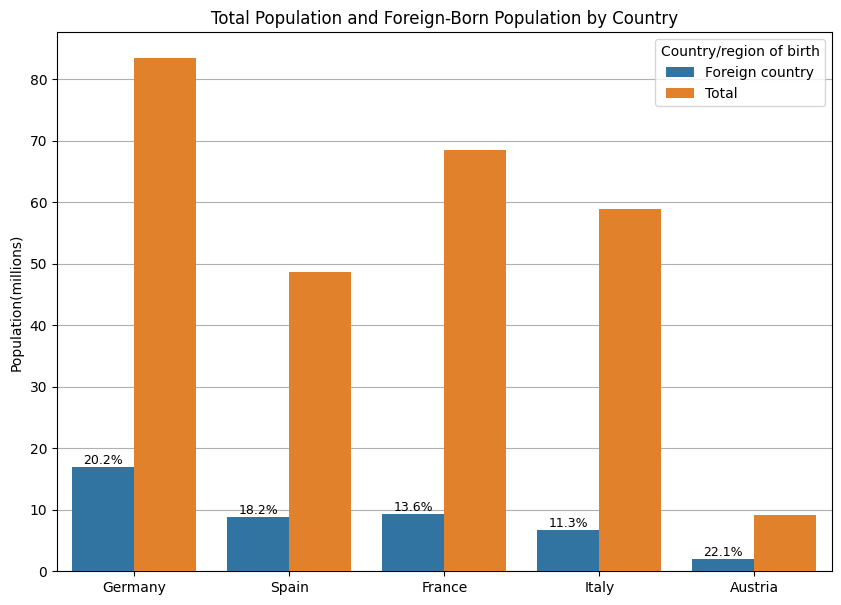

In [ ]:
url_pop_by_country_of_birth = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/population_by_country_of_birth.csv"
df_population_by_country_of_birth = pd.read_csv(url_pop_by_country_of_birth,usecols=['Country/region of birth', 'geo', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']).query('TIME_PERIOD == 2024')
df_population_by_country_of_birth["OBS_VALUE"] = df_population_by_country_of_birth["OBS_VALUE"]/1000000
df_population_by_country_of_birth_wide = df_population_by_country_of_birth.pivot(index='Geopolitical entity (reporting)',
    columns='Country/region of birth',
    values='OBS_VALUE'
).reset_index()
df_population_by_country_of_birth_wide["Percentage Foreign-Born"] = df_population_by_country_of_birth_wide["Foreign country"]/df_population_by_country_of_birth_wide["Total"]*100
df_population_by_country_of_birth = df_population_by_country_of_birth.merge(
    df_population_by_country_of_birth_wide[['Geopolitical entity (reporting)', 'Percentage Foreign-Born']],
    on='Geopolitical entity (reporting)',
    how='left'
)


fig, ax = plt.subplots(figsize=(10, 7))

df_population_by_country_of_birth_5countries = df_population_by_country_of_birth[df_population_by_country_of_birth['geo'].isin(countries_highest_number_immigrates)]
df_population_by_country_of_birth_5countries = pd.concat([df_population_by_country_of_birth_5countries.query('geo!="AT"'), df_population_by_country_of_birth_5countries.query('geo=="AT"')], ignore_index=True)


plot_for_pop_by_country_of_birth = sns.barplot(data=df_population_by_country_of_birth_5countries, y='OBS_VALUE', x='Geopolitical entity (reporting)', hue='Country/region of birth', ax=ax, zorder=3)

bars = plot_for_pop_by_country_of_birth.patches

df_foreign = df_population_by_country_of_birth_5countries.query('`Country/region of birth` == "Foreign country"').reset_index(drop=True)

foreign_index = 0

for bar in bars:
    if foreign_index < len(df_foreign):
        if abs(bar.get_height() - df_foreign.loc[foreign_index, 'OBS_VALUE']) < 1e-3:
            percent = df_foreign.loc[foreign_index, 'Percentage Foreign-Born']
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{percent:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9,
                color='black'
            )
            foreign_index += 1

ax.set_title('Total Population and Foreign-Born Population by Country')
ax.set_xlabel('')
ax.set_ylabel('Population(millions)')
ax.grid(True, axis='y', zorder=0)

plt.show()

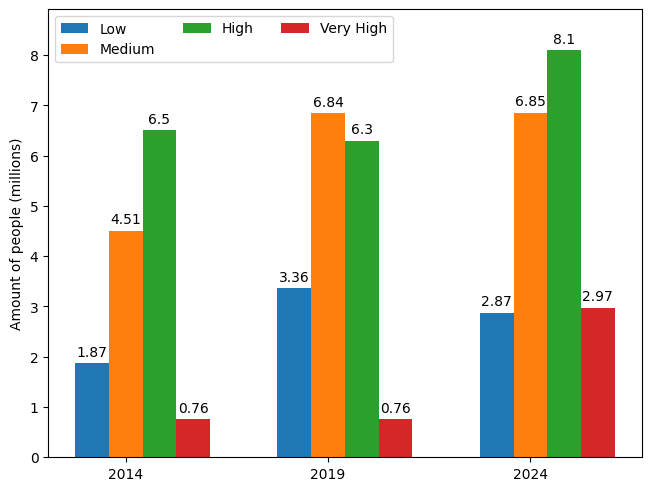

In [ ]:
# Human_D_of_citizicitizenship
url_H = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/human.csv"
data_HD = pd.read_csv(url_H,usecols=['citizen', 'Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE'])
data_HD['OBS_VALUE'] = data_HD['OBS_VALUE'] / 1000000
data_HD['OBS_VALUE'] = data_HD['OBS_VALUE'].round(2)
grouped = data_HD.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0)
grouped = grouped.transpose()
grouped.columns = ['High','Low','Medium',"Very High"]
grouped = grouped[['Low', 'Medium', 'High', 'Very High']]
years = grouped.index.tolist()
categories = grouped.columns.tolist()
values = grouped.values

x = np.arange(len(years))  * 1.5
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for category  in categories:
    offset = width * multiplier
    rects = ax.bar(x + offset, grouped[category], width, label=category)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Amount of people (millions)')
ax.set_title('')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, grouped.values.max() * 1.1)

plt.show()

(0.0, 1.837)

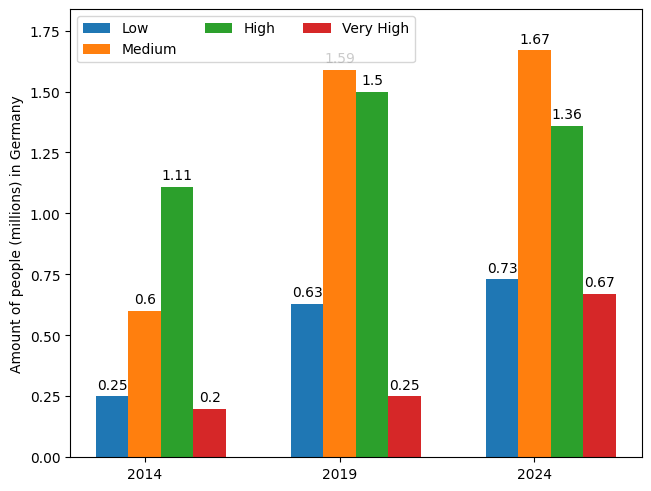

In [ ]:
data_HD_G =data_HD[data_HD['Geopolitical entity (reporting)']=='Germany']
groupedG = data_HD_G.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0)
groupedG = groupedG.transpose()
groupedG.columns = ['High','Low','Medium',"Very High"]
groupedG = groupedG[['Low', 'Medium', 'High', 'Very High']]
years = groupedG.index.tolist()
categories = groupedG.columns.tolist()
values = groupedG.values

x = np.arange(len(years))  * 1.5
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for category  in categories:
    offset = width * multiplier
    rects = ax.bar(x + offset, groupedG[category], width, label=category)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Amount of people (millions) in Germany')
ax.set_title('')
ax.set_xticks(x + width, years)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, groupedG.values.max() * 1.1)


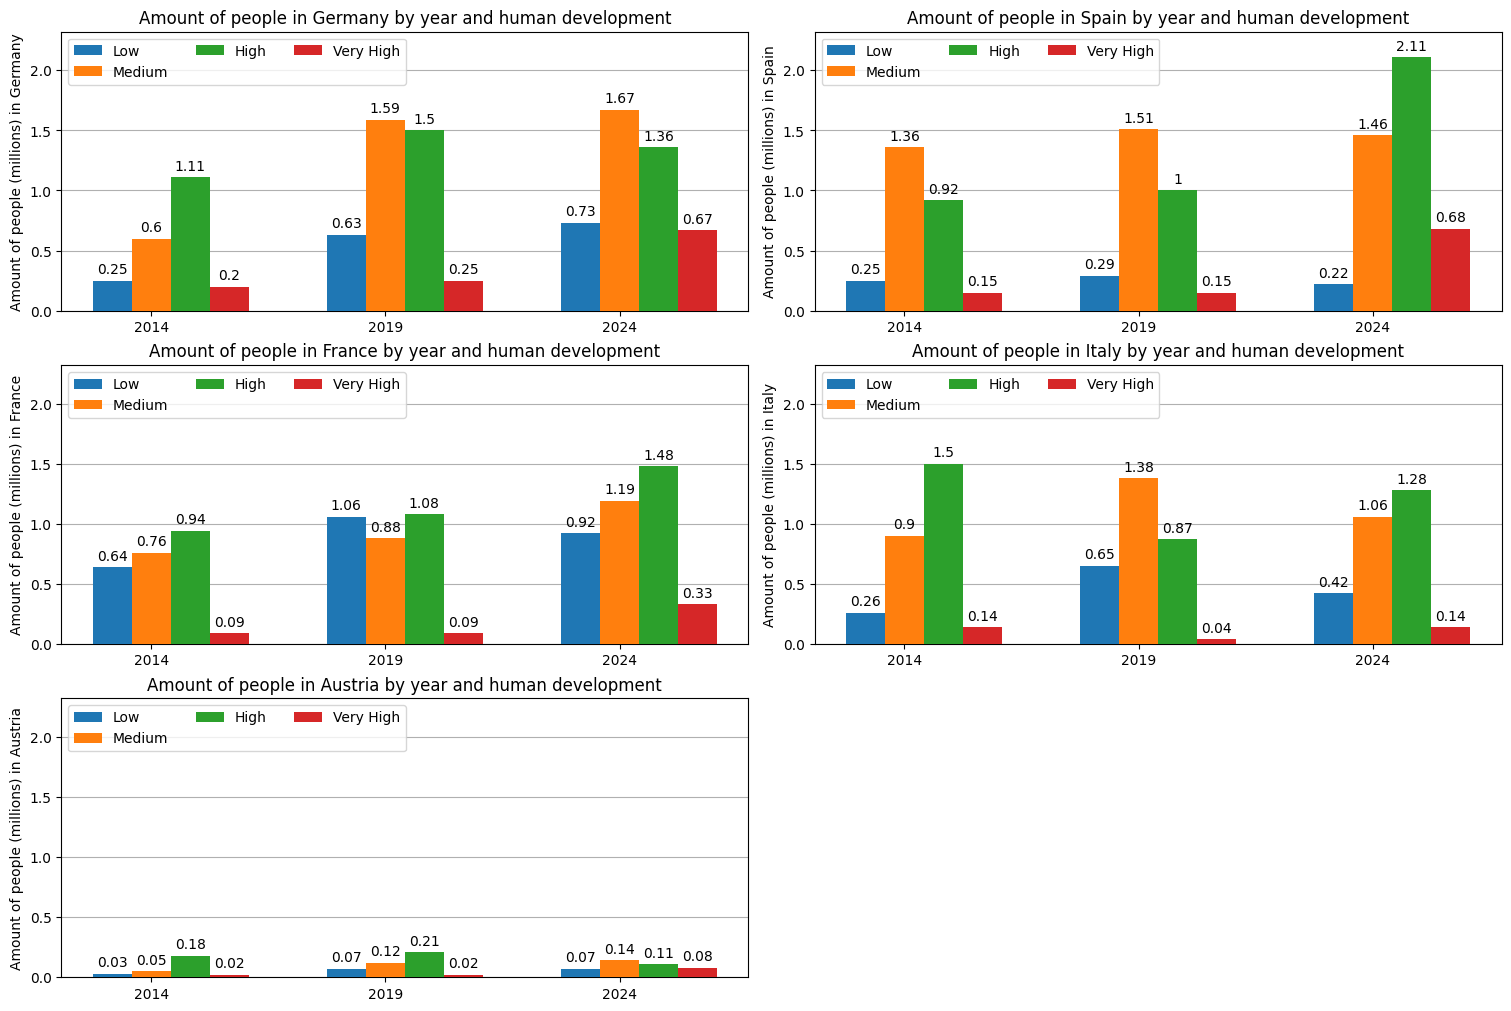

In [ ]:
def plot_country(ax, data, country_name, max_y):
    data_country = data[data['Geopolitical entity (reporting)'] == country_name]
    grouped = data_country.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0).transpose()
    grouped.columns = ['High', 'Low', 'Medium', 'Very High']
    grouped = grouped[['Low', 'Medium', 'High', 'Very High']]

    years = grouped.index.tolist()
    categories = grouped.columns.tolist()
    x = np.arange(len(years)) * 1.5
    width = 0.25
    multiplier = 0
    #fig, ax = plt.subplots(layout='constrained')
    for category in categories:
        offset = width * multiplier
        rects = ax.bar(x + offset, grouped[category], width, label=category, zorder=3)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel(f'Amount of people (millions) in {country_name}')
    ax.set_title(f'Amount of people in {country_name} by year and human development')
    ax.set_xticks(x + width, years)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, max_y*1.1)
    ax.grid(True, axis='y', zorder=0)
    #ax.set_ylim(0, grouped.values.max() * 1.1)
    #plt.show()

countries = ['Germany', 'Spain', 'France', 'Italy', 'Austria']

max_y = 0
for country in countries:
    data_country = data_HD[data_HD['Geopolitical entity (reporting)'] == country]
    grouped = data_country.groupby(['citizen', 'TIME_PERIOD'])['OBS_VALUE'].sum().unstack(fill_value=0).transpose()
    total = grouped.max(axis=1).max()
    if total > max_y:
        max_y = total

fig, ax = plt.subplots(3, 2, figsize=(15, 10), layout='constrained')
axes = ax.flatten()
for i, country in enumerate(countries):
    plot_country(axes[i], data_HD, country, max_y)
for j in range(len(countries), len(axes)):
    fig.delaxes(axes[j])
plt.show()

/tmp/ipykernel_12051/3725520334.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.set_ticklabels([0, 2, 4, 6, 8, 10, 12])
/tmp/ipykernel_12051/3725520334.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar2.set_ticklabels([0, 10, 20, 30, 40])


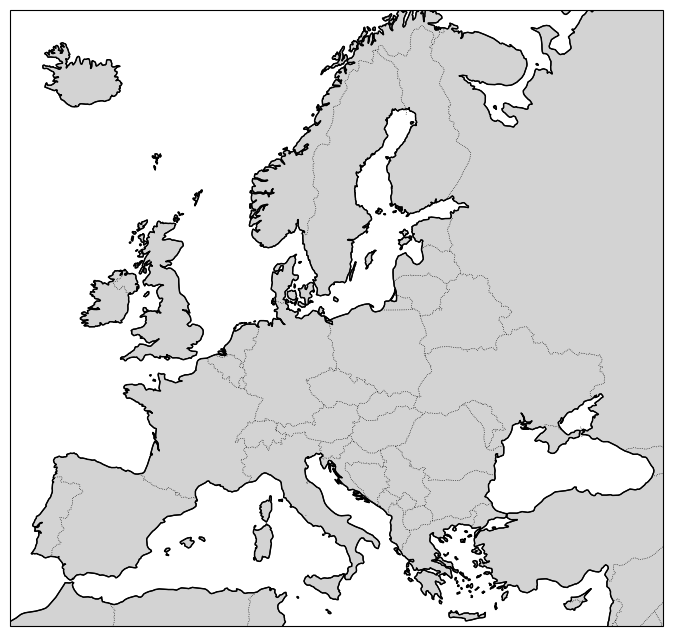

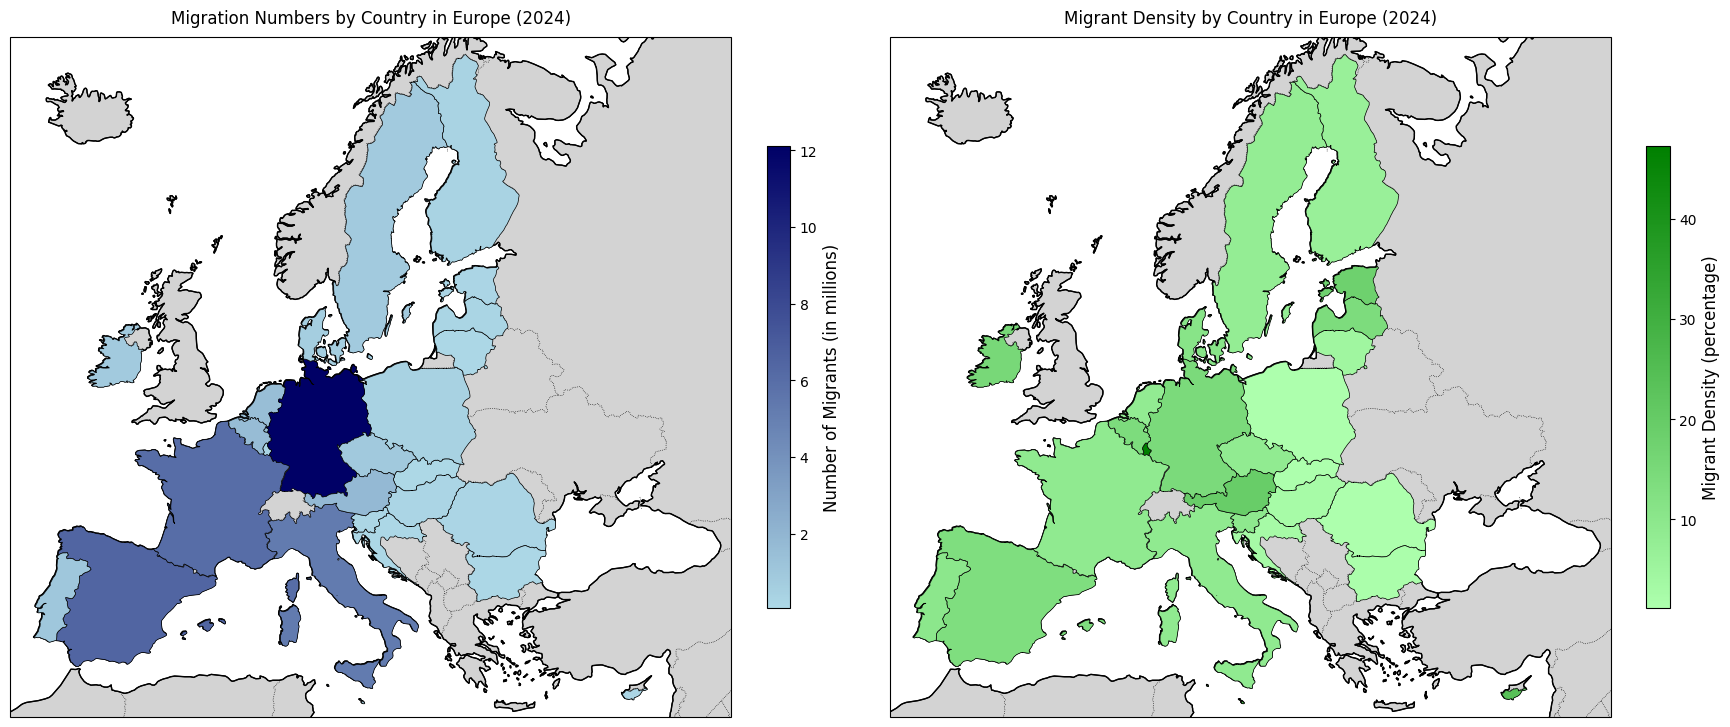

In [ ]:
url1 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/points_of_country.csv"
url2 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/MigrantsAndCitizens.csv"
data_frame_by_points_of_country = pd.read_csv(url1, usecols=['Country', 'ISO-ALPHA-2', 'Latitude', 'Longitude'])
df_density_migrants = pd.read_csv(url2).drop(['STRUCTURE_NAME','Time frequency', 'age', 'Age class', 'Unit of measure', 'sex', 'Sex', 'Time',
                                              'Observation value', 'Observation status (Flag) V2 structure', 'Confidentiality status (flag)',
                                              'Country of citizenship', 'unit', 'STRUCTURE', 'OBS_FLAG', 'CONF_STATUS', 'STRUCTURE_ID',
                                              'TIME_PERIOD', 'freq', 'Geopolitical entity (reporting)'], axis=1)
df_density_migrants = df_density_migrants.pivot(index='geo', columns='citizen', values='OBS_VALUE').reset_index()
df_density_migrants['density'] = df_density_migrants['FOR_STLS'] / df_density_migrants['TOTAL']
df_density_migrants = df_density_migrants.drop(['FOR_STLS', 'TOTAL'], axis=1)
#df_not_and_from_eu_wide = df_not_and_from_eu[df_not_and_from_eu['geo'].isin(countries_highest_number_immigrates)].pivot(index='geo', columns='category', values='OBS_VALUE_milion').reset_index()
#df_density_migrants = df_density_migrants.groupby(['citizen', 'geo'])['OBS_VALUE'].sum()
data = {
    "geo": list(df['geo'].unique())
}

points = (pd.merge(pd.DataFrame(data), data_frame_by_points_of_country, left_on='geo', right_on='ISO-ALPHA-2'))

nove_frame = pd.merge(points, df_sorted_by_number_immigrates, on="geo")
nove_frame = pd.merge(nove_frame, df_density_migrants, on="geo")

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.LambertConformal(15.0, 50.0)})
ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

'''cmap = LinearSegmentedColormap.from_list("custom_viridis", [
    (0.267004, 0.004874, 0.329415),
    (0.229739, 0.322470, 0.545267),
    (0.127568, 0.566949, 0.550556),
    (0.369214, 0.788888, 0.382914),
    (0.993248, 0.906157, 0.143936)
])'''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.LambertConformal(15.0, 50.0)})

for ax in [ax1, ax2]:
    ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

cmap = LinearSegmentedColormap.from_list("light_blue_to_dark_blue", [
    (0.678, 0.847, 0.902),  # Светло-голубой (light sky blue)
    (0.0, 0.0, 0.4)         # Чуть темнее синий (slightly darker blue)
])
cmap2 = LinearSegmentedColormap.from_list("light_green_to_dark_green", [
    (0.678, 1.0, 0.678),  # Светло-зеленый (light green)
    (0.0, 0.5, 0.0)       # Темно-зеленый (dark green)
])

norm = plt.Normalize(nove_frame['OBS_VALUE'].min(), nove_frame['OBS_VALUE'].max())
migration_dict = dict(zip(nove_frame['Country'], nove_frame['OBS_VALUE']))
for country in shpreader.Reader(shpreader.natural_earth('50m', 'cultural', 'admin_0_countries')).records():
    if country.attributes['NAME_LONG'] in migration_dict:
        ax1.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=cmap(norm(migration_dict[country.attributes['NAME_LONG']])),
                          edgecolor='black', linewidth=0.5)
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax1, shrink=0.6, pad=0.04)
cbar1.set_label('Number of Migrants (in millions)', fontsize=12)
cbar1.set_ticklabels([0, 2, 4, 6, 8, 10, 12])
ax1.set_title('Migration Numbers by Country in Europe (2024)', fontsize=12, pad=10)


migration_dict2 = dict(zip(nove_frame['Country'], nove_frame['density']))
norm2 = plt.Normalize(nove_frame['density'].min(), nove_frame['density'].max())
for country in shpreader.Reader(shpreader.natural_earth('50m', 'cultural', 'admin_0_countries')).records():
    if country.attributes['NAME_LONG'] in migration_dict2:
        ax2.add_geometries([country.geometry], ccrs.PlateCarree(),
                           facecolor=cmap2(norm2(migration_dict2[country.attributes['NAME_LONG']])),
                           edgecolor='black', linewidth=0.5)
cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap2, norm=norm2), ax=ax2, shrink=0.6, pad=0.04)
cbar2.set_label('Migrant Density (percentage)', fontsize=12)
cbar2.set_ticklabels([0, 10, 20, 30, 40])
ax2.set_title('Migrant Density by Country in Europe (2024)', fontsize=12, pad=10)


plt.tight_layout()
plt.show()

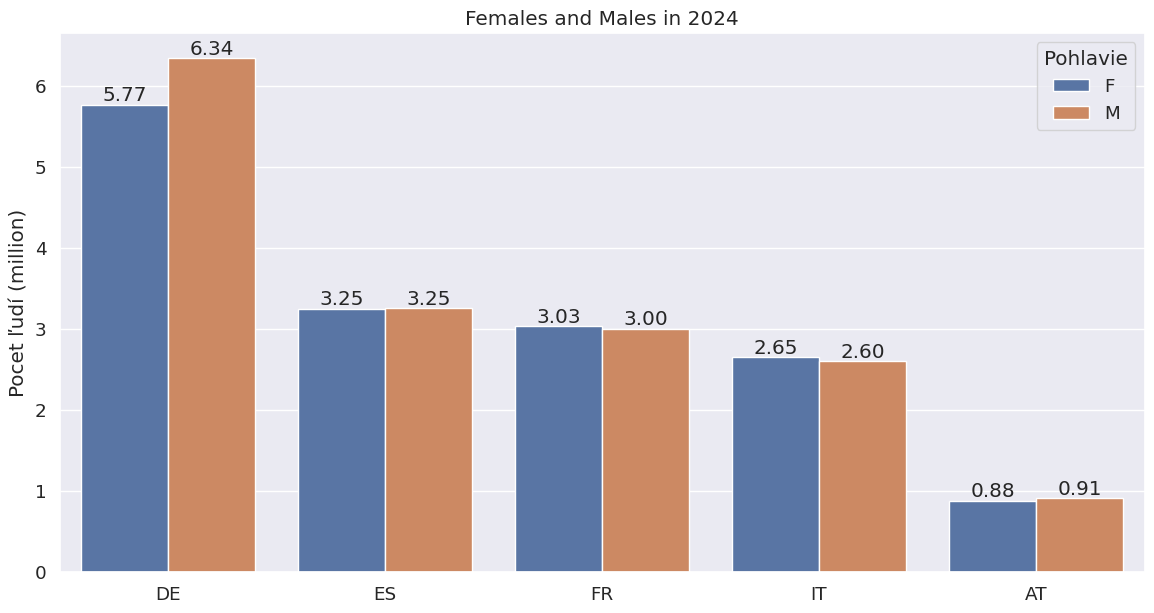

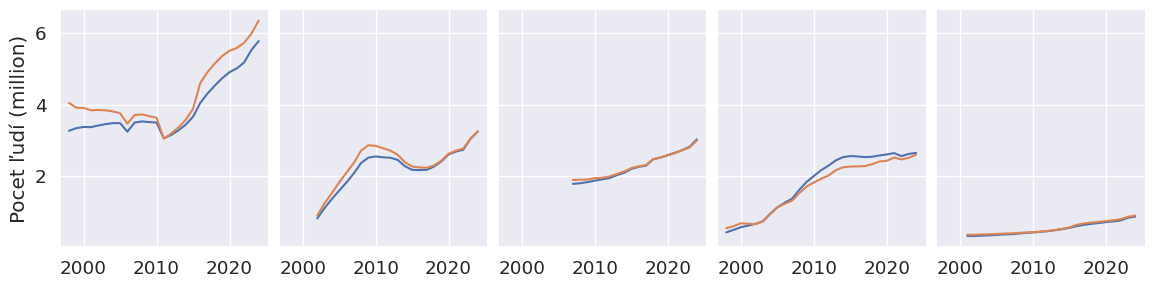

In [ ]:
df['OBS_VALUE_milion'] = df['OBS_VALUE'] /1000000
osnova = df[df['geo'].isin(countries_highest_number_immigrates)]
osnova = pd.concat([osnova.query('geo!="AT"'), osnova.query('geo=="AT"')], ignore_index=True)

sns.set_theme(font_scale=1.2)
fig, axes = plt.subplots(figsize=(14, 7))

barplot = sns.barplot(data=osnova.query("TIME_PERIOD == 2024"),
            x='geo', y='OBS_VALUE_milion', hue='sex', ax=axes)
axes.set_ylabel('Pocet ľudí (million)')
axes.set_xlabel(None)
axes.set_title('Females and Males in 2024')
for container in barplot.containers:
    axes.bar_label(container, fmt='%.2f')
axes.legend(title='Pohlavie')

grid = sns.relplot(data=osnova, x='TIME_PERIOD', y='OBS_VALUE_milion',
                   col='geo', col_wrap=5, kind="line", height=3,
                   aspect=1,hue='sex')

grid.set_axis_labels('', 'Pocet ľudí (million)')
grid.set_titles('') #"{col_name}"
# Зафігачив, аби обидва плоти були одного розміру
grid.figure.set_size_inches(12.18, 4)
grid.figure.subplots_adjust(wspace=0.05,)
grid._legend.remove()

#Редагував для читабельності, оптимізував +стилізація
# -Н


plt.show()
pass

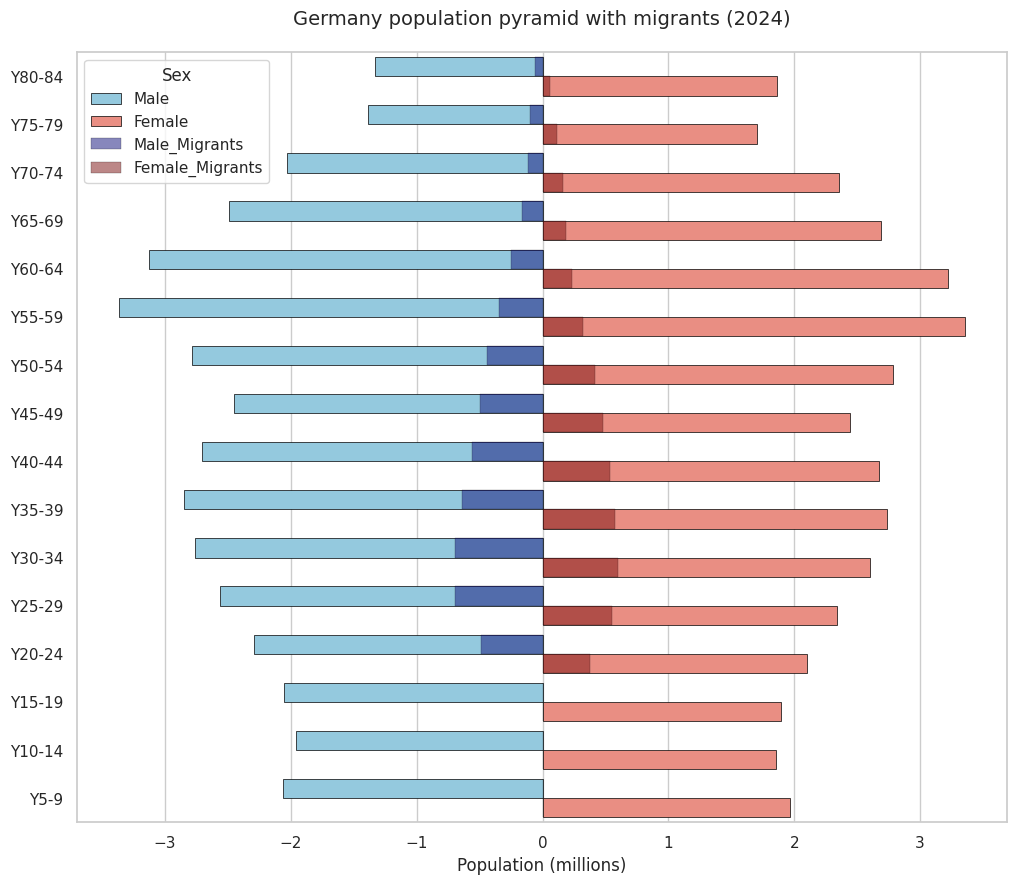

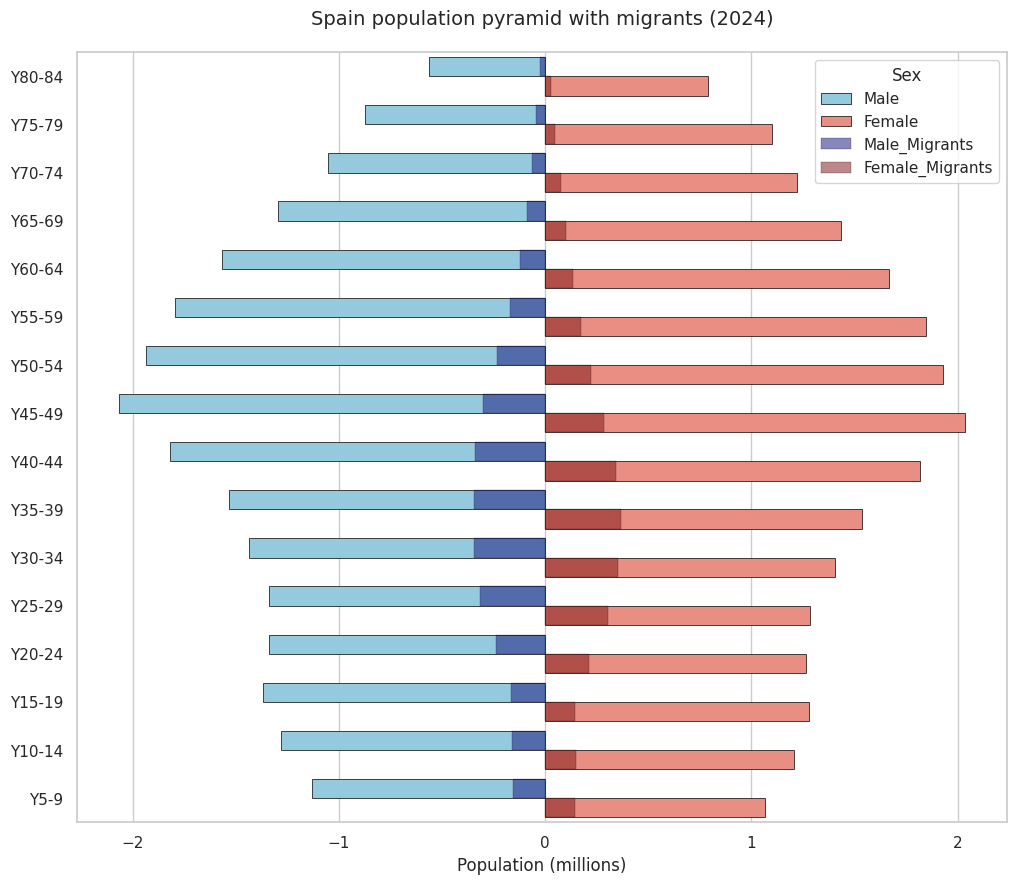

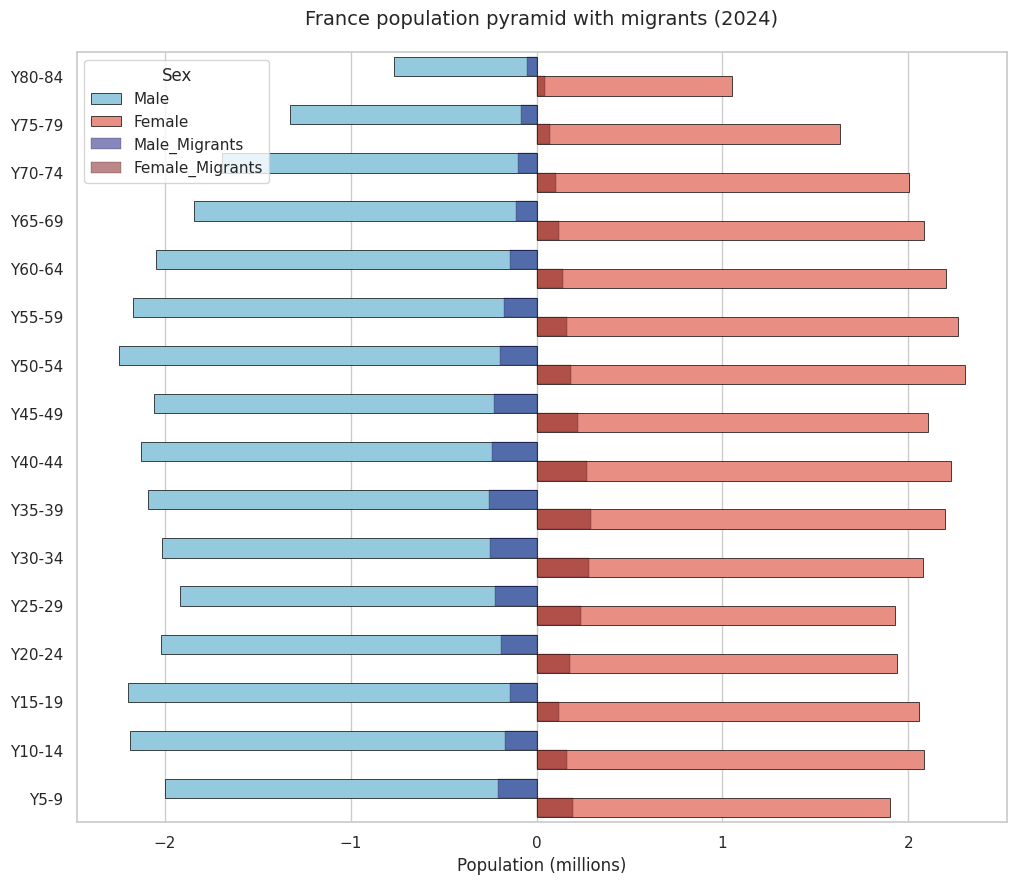

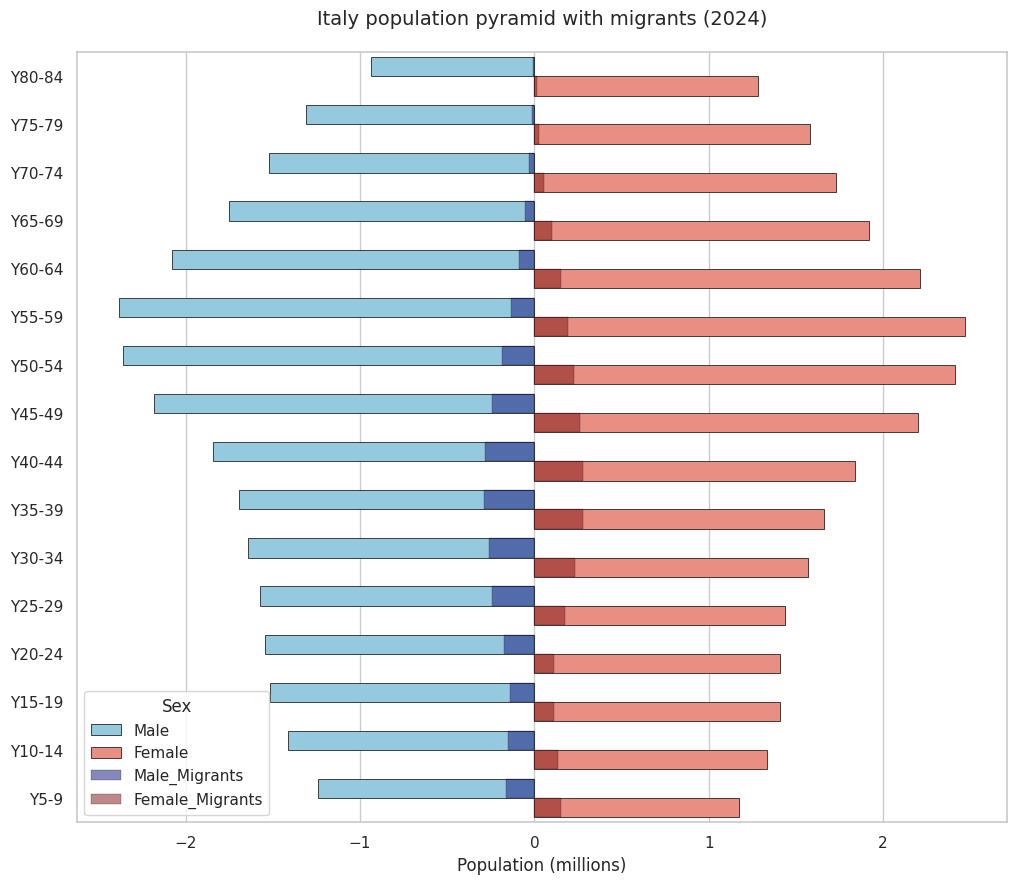

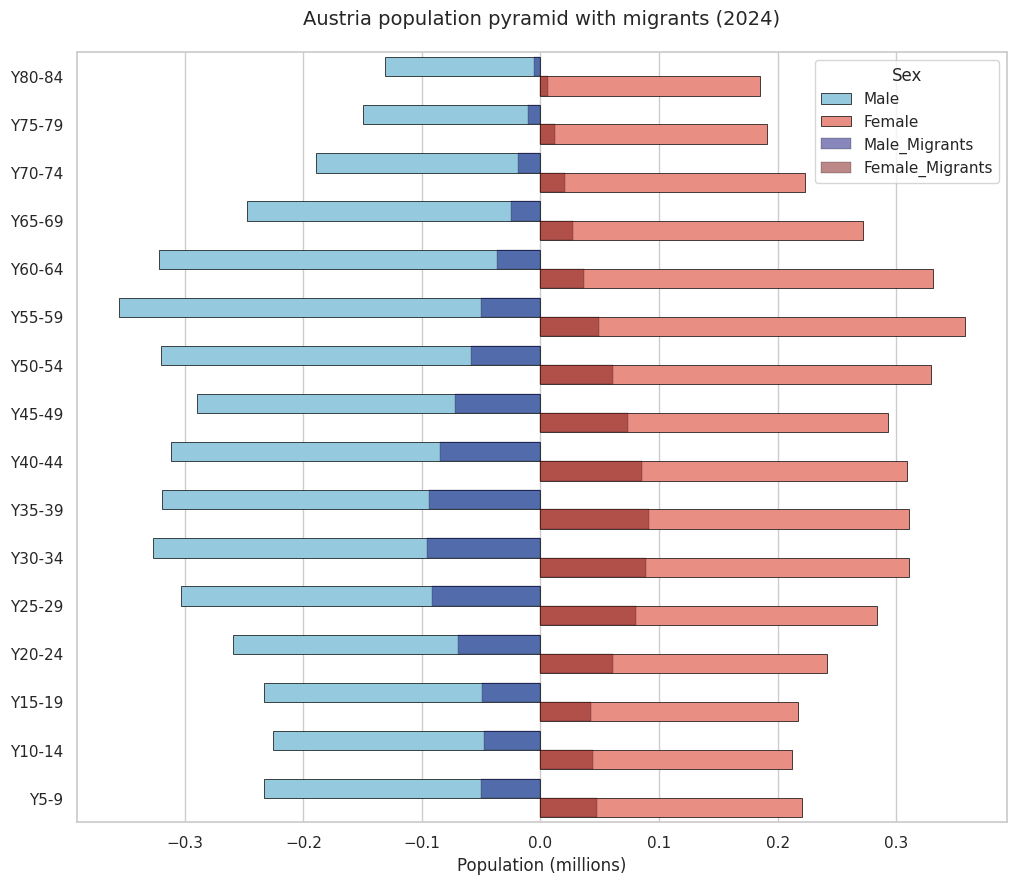

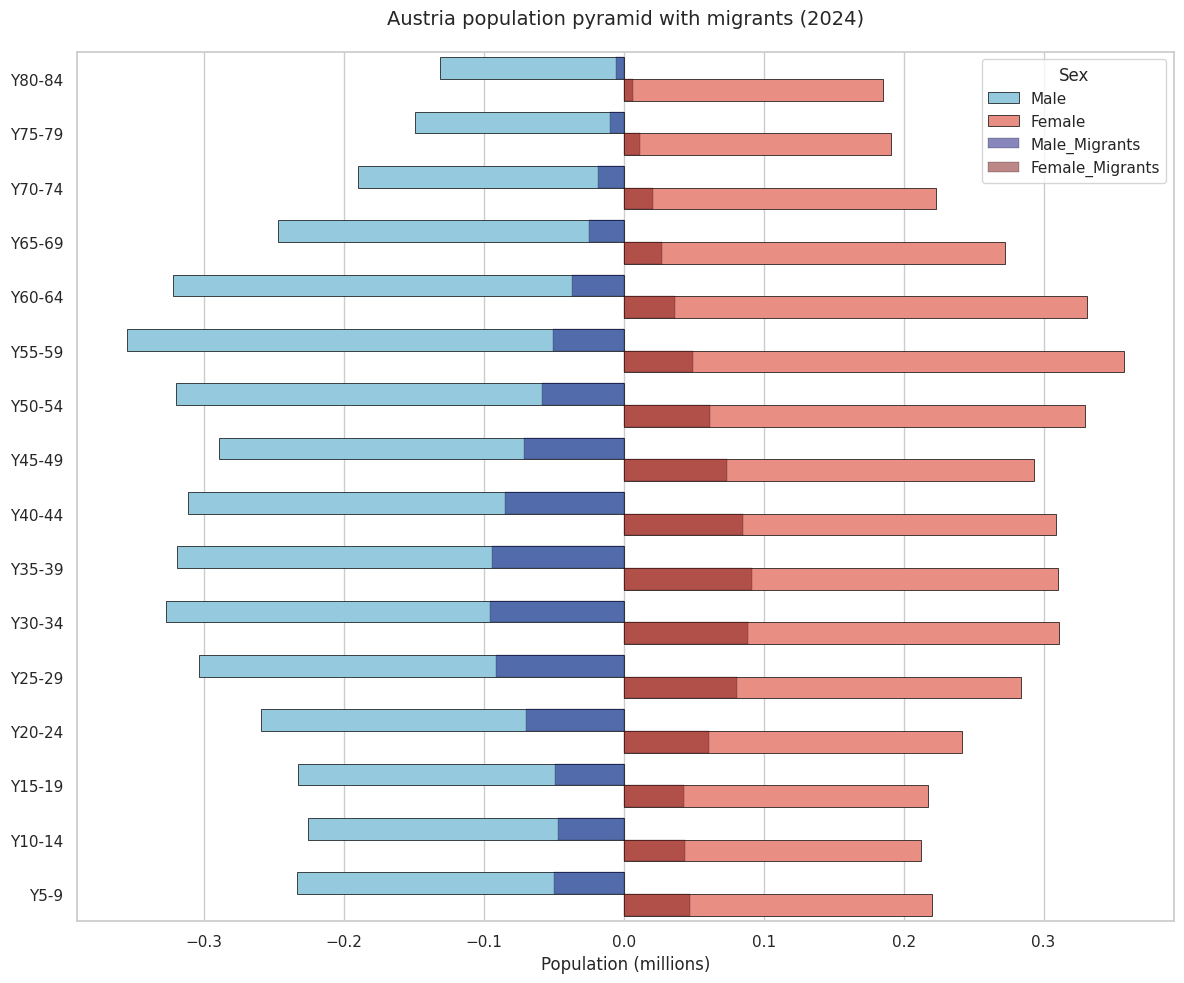

In [ ]:
urlDemo = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/ForDemoPiramid.csv"

df_for_demo_piramids = pd.read_csv(urlDemo).drop(['STRUCTURE','STRUCTURE_ID', 'CONF_STATUS', 'OBS_FLAG', 'freq', 'TIME_PERIOD', 'unit'], axis=1)

def draw_piramid(name, short_name, df_for_demo_piramids):
  age_order=['Y80-84',
  'Y75-79',
  'Y70-74',
  'Y65-69',
  'Y60-64',
  'Y55-59',
  'Y50-54',
  'Y45-49',
  'Y40-44',
  'Y35-39',
  'Y30-34',
  'Y25-29',
  'Y20-24',
  'Y15-19',
  'Y10-14',
  'Y5-9']
  df_for_demo_piramids_M_total = df_for_demo_piramids.query('sex=="M"').query('geo==@short_name').query('citizen=="TOTAL"')
  df_for_demo_piramids_M_total['OBS_VALUE_milion'] = -df_for_demo_piramids_M_total['OBS_VALUE']/1000000
  df_for_demo_piramids_M_total = df_for_demo_piramids_M_total.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Male'}).rename(columns={'age': 'Age'})

  df_for_demo_piramids_F_total = df_for_demo_piramids.query('sex=="F"').query('geo==@short_name').query('citizen=="TOTAL"')
  df_for_demo_piramids_F_total['OBS_VALUE_milion'] = df_for_demo_piramids_F_total['OBS_VALUE']/1000000
  df_for_demo_piramids_F_total = df_for_demo_piramids_F_total.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Female'}).rename(columns={'age': 'Age'})


  df_for_demo_piramids_M_migr = df_for_demo_piramids.query('sex=="M"').query('geo==@short_name').query('citizen=="FOR_STLS"')
  df_for_demo_piramids_M_migr['OBS_VALUE_milion'] = -df_for_demo_piramids_M_migr['OBS_VALUE']/1000000
  df_for_demo_piramids_M_migr = df_for_demo_piramids_M_migr.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Male_Migrants'}).rename(columns={'age': 'Age'})
  if short_name == 'DE':
    missing_ages = ["Y5-9", "Y10-14", "Y15-19"]
    df_missing = pd.DataFrame({
        'Age': missing_ages,
        'Male_Migrants': 0.0
    })
    df_for_demo_piramids_M_migr = pd.concat([
        df_for_demo_piramids_M_migr,
        df_missing
    ], ignore_index=True)

  df_for_demo_piramids_F_migr = df_for_demo_piramids.query('sex=="F"').query('geo==@short_name').query('citizen=="FOR_STLS"')
  df_for_demo_piramids_F_migr['OBS_VALUE_milion'] = df_for_demo_piramids_F_migr['OBS_VALUE']/1000000
  df_for_demo_piramids_F_migr = df_for_demo_piramids_F_migr.drop(['sex', 'geo', 'OBS_VALUE', 'citizen'], axis=1).rename(columns={'OBS_VALUE_milion': 'Female_Migrants'}).rename(columns={'age': 'Age'})
  if short_name == 'DE':
    missing_ages = ["Y5-9", "Y10-14", "Y15-19"]
    df_missing = pd.DataFrame({
        'Age': missing_ages,
        'Female_Migrants': 0.0
    })
    df_for_demo_piramids_F_migr = pd.concat([
        df_for_demo_piramids_F_migr,
        df_missing
    ], ignore_index=True)

  df_for_demo_piramids_total = pd.merge(df_for_demo_piramids_M_total, df_for_demo_piramids_F_total, on='Age')
  df_for_demo_piramids_migr = pd.merge(df_for_demo_piramids_M_migr, df_for_demo_piramids_F_migr, on='Age')
  df_for_demo_piramids = pd.merge(df_for_demo_piramids_total, df_for_demo_piramids_migr, on='Age')

  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(12, 10))

  sns.barplot(
      data=df_for_demo_piramids.melt(id_vars="Age", value_vars=["Male", "Female"], var_name="Sex", value_name="Population"),
      y="Age",
      x="Population",
      hue="Sex",
      order=age_order,
      palette={"Male": "skyblue", "Female": "salmon"},
      edgecolor="black",
      linewidth=0.5,
  )

  sns.barplot(
      data=df_for_demo_piramids.melt(id_vars="Age", value_vars=["Male_Migrants", "Female_Migrants"], var_name="Sex", value_name="Migrants"),
      y="Age",
      x="Migrants",
      hue="Sex",
      order=age_order,
      palette={"Male_Migrants": "darkblue", "Female_Migrants": "darkred"},
      alpha=0.5,
      edgecolor="black",
      linewidth=0.3,
  )

  plt.title(name + " population pyramid with migrants (2024)", fontsize=14, pad=20)
  plt.xlabel("Population (millions)")
  plt.ylabel("")



#GERMANY
draw_piramid('Germany', 'DE', df_for_demo_piramids)
#GERMANY

#SPAIN
draw_piramid('Spain', 'ES', df_for_demo_piramids)
#SPAIN

#FRANCE
draw_piramid('France', 'FR', df_for_demo_piramids)
#FRANCE

#ITALY
draw_piramid('Italy', 'IT', df_for_demo_piramids)
#ITALY

#AUSTRIA
draw_piramid('Austria', 'AT', df_for_demo_piramids)
#AUSTRIA
draw_piramid('Austria', 'AT', df_for_demo_piramids)
plt.tight_layout()
plt.show()

citizen,age,EU,Not EU
0,Y5-14,1.225758,3.072214
1,Y15-24,1.420207,3.578497
2,Y25-34,2.393325,6.254321
3,Y35-44,2.786243,5.941431
4,Y45-54,2.444190,4.106872
5,Y55-64,1.661142,2.452672
6,Y65-74,0.907470,1.377209
7,Y75-84,0.449535,0.640517


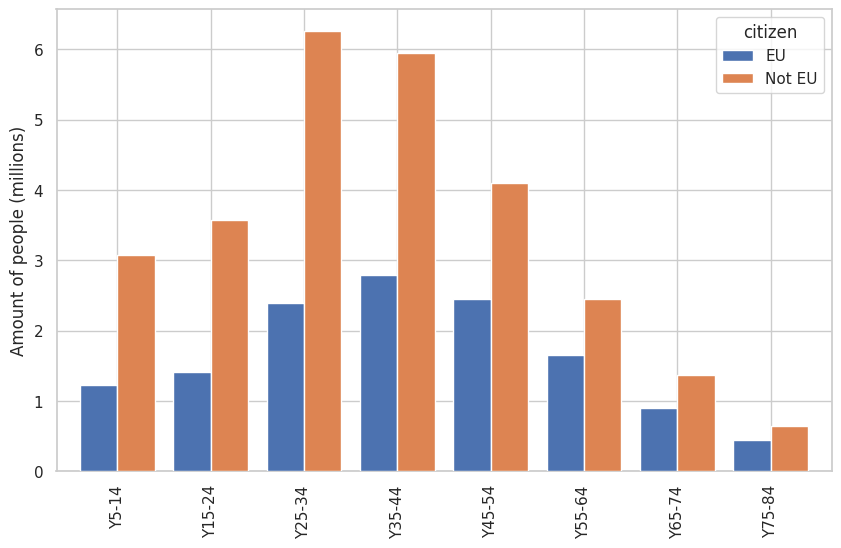

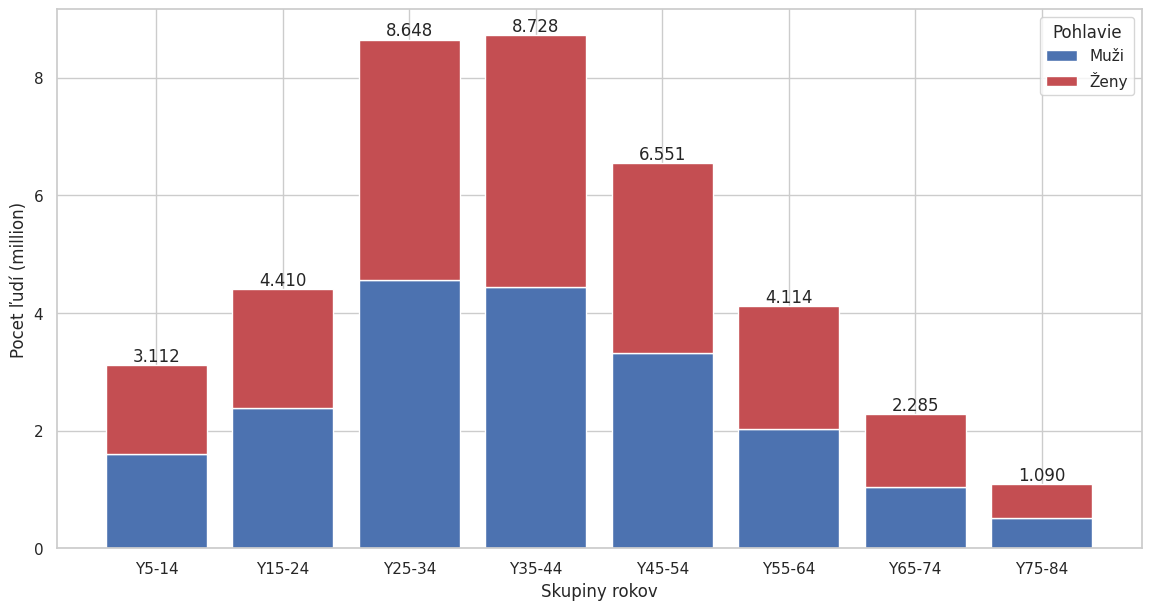

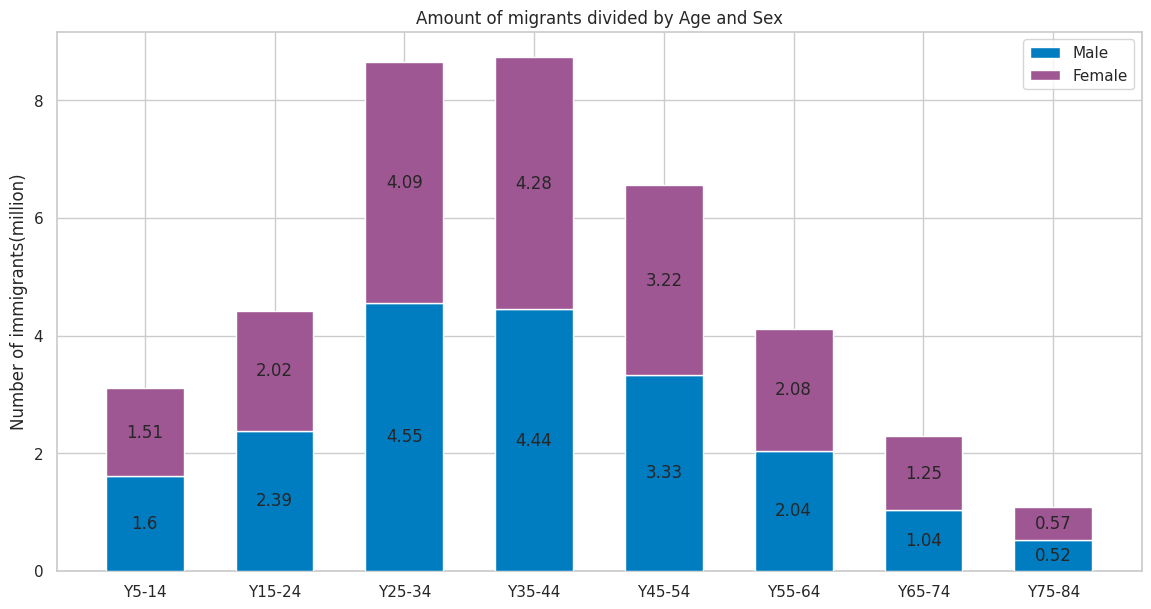

In [ ]:
url2 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/age_data_2.csv"
urlEu_Ages = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/eu_not_euGeneral_by_ages.csv"
df_by_ages_gender = (pd.read_csv(url2, usecols=['age', 'sex', 'OBS_VALUE', 'TIME_PERIOD'])
                    .query('TIME_PERIOD == 2024 & sex != "T"')
                    .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE'] / 1000000)
                    .groupby(['age', 'sex'])['OBS_VALUE_milion']
                    .sum()
                    .reset_index())
df_by_ages_cship = (pd.read_csv(urlEu_Ages, usecols=['age', 'citizen', 'OBS_VALUE'])
                    .assign(OBS_VALUE_milion=lambda df: df['OBS_VALUE'] / 1000000))

df_by_ages_gender  = (df_by_ages_gender
                      .query('age!="Y15-64"').iloc[:-6,:]
                      .sort_values(by='age'))
df_by_ages_gender = pd.concat([df_by_ages_gender.query('age == "Y5-9"'),
                               df_by_ages_gender[df_by_ages_gender['age'] != 'Y5-9']])
df_by_ages_cship = pd.concat([df_by_ages_cship.query('age == "Y5-9"'),
                               df_by_ages_cship[df_by_ages_cship['age'] != 'Y5-9']])

df_by_ages_cship = df_by_ages_cship[['age', 'citizen', 'OBS_VALUE', 'OBS_VALUE_milion']]


df_by_ages_gender_men = df_by_ages_gender.query('sex == "M"')
df_by_ages_gender_women = df_by_ages_gender.query('sex == "F"')
df_by_ages_cs_eu = df_by_ages_cship.query('citizen == "EU27_2020_FOR"')
df_by_ages_cs_noteu = df_by_ages_cship.query('citizen == "FOR_STLS"')

for i in range(5, 80, 10):
  df_by_ages_gender_men.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_gender_men.iloc[int(i/5), 0] = f'Y{i}-{i+9}'
  df_by_ages_gender_women.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_gender_women.iloc[int(i/5), 0] = f'Y{i}-{i+9}'

  df_by_ages_cs_eu.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_cs_eu.iloc[int(i/5), 0] = f'Y{i}-{i+9}'
  df_by_ages_cs_noteu.iloc[int(i/5-1), 0] = f'Y{i}-{i+9}'
  df_by_ages_cs_noteu.iloc[int(i/5), 0] = f'Y{i}-{i+9}'


df_by_ages_gender = pd.concat([df_by_ages_gender_men, df_by_ages_gender_women])
df_by_ages_cship = pd.concat([df_by_ages_cs_eu, df_by_ages_cs_noteu])

df_by_ages_gender = (df_by_ages_gender
                     .groupby(by=['age', 'sex'])['OBS_VALUE_milion']
                     .sum()
                     .reset_index())
df_by_ages_cship = (df_by_ages_cship
                     .groupby(by=['age', 'citizen'])['OBS_VALUE_milion']
                     .sum()
                     .reset_index())
df_by_ages_gender = pd.concat([df_by_ages_gender.query('age == "Y5-14"'),
                               df_by_ages_gender[df_by_ages_gender['age'] != 'Y5-14']])
df_by_ages_cship = pd.concat([df_by_ages_cship.query('age == "Y5-14"'),
                               df_by_ages_cship[df_by_ages_cship['age'] != 'Y5-14']])

df_by_ages_cship = df_by_ages_cship.pivot(index='age', columns='citizen', values='OBS_VALUE_milion').reset_index()

df_by_ages_cship['Not EU'] = df_by_ages_cship['FOR_STLS'] - df_by_ages_cship['EU27_2020_FOR']
df_by_ages_cship = df_by_ages_cship[['age', 'EU27_2020_FOR', 'Not EU']]
df_by_ages_cship = pd.concat([
    df_by_ages_cship.query('age == "Y5-14"'),
    df_by_ages_cship[df_by_ages_cship['age'] != 'Y5-14']
])
df_by_ages_cship = df_by_ages_cship.rename(columns={'EU27_2020_FOR':'EU'})
df_by_ages_cship = df_by_ages_cship.reset_index(drop=True)
df_by_ages_cship = df_by_ages_cship.iloc[0:8]
display(df_by_ages_cship)

df_by_ages_cship = df_by_ages_cship.set_index('age')
ax = df_by_ages_cship.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.8,
    zorder=3
)
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Amount of people (millions)')
ax.grid(True, axis='y', zorder=0)


df_by_ages_gender_men = df_by_ages_gender.query('sex == "M"')
df_by_ages_gender_women = df_by_ages_gender.query('sex == "F"')

fig, axes = plt.subplots(figsize=(14, 7))

male_plot = axes.bar(df_by_ages_gender_men['age'], df_by_ages_gender_men['OBS_VALUE_milion'],
                     color='b',)
female_plot = axes.bar(df_by_ages_gender_women['age'], df_by_ages_gender_women['OBS_VALUE_milion'],
                       bottom=df_by_ages_gender_men['OBS_VALUE_milion'], color='r')

axes.set_ylabel('Pocet ľudí (million)')
axes.set_xlabel('Skupiny rokov')
axes.legend(["Muži", "Ženy"], title='Pohlavie', loc="upper right")
axes.bar_label(female_plot, fmt='%.3f')




df_by_ages_gender_wide = df_by_ages_gender.pivot(index='age', columns='sex', values='OBS_VALUE_milion').reset_index()
df_by_ages_gender_wide['Total'] = df_by_ages_gender_wide['M'] + df_by_ages_gender_wide['F']
row = df_by_ages_gender_wide[df_by_ages_gender_wide['age'] == 'Y5-14']
df_by_ages_gender_wide = df_by_ages_gender_wide[df_by_ages_gender_wide['age'] != 'Y5-14']
df_by_ages_gender_wide = pd.concat([row, df_by_ages_gender_wide], ignore_index=True)
dict_by_ages_gender = {
    'Male': df_by_ages_gender_wide['M'],
    'Female': df_by_ages_gender_wide['F'],
}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(len(df_by_ages_gender_wide['age']))

for sex, count in dict_by_ages_gender.items():
    if sex == 'Male':
      p = ax.bar(df_by_ages_gender_wide['age'], count, width, label=sex, bottom=bottom, color='#007dc0', zorder=3)
    else:
      p = ax.bar(df_by_ages_gender_wide['age'], count, width, label=sex, bottom=bottom, color='#9e5793', zorder=3)
    bottom += count

    rounded_counts = [str(round(val, 2)) for val in count]
    ax.bar_label(p, labels=rounded_counts, label_type='center')

ax.set_title('Amount of migrants divided by Age and Sex')
ax.set_ylabel('Number of immigrants(million)')
ax.grid(True, axis='y', zorder=0)
ax.legend()




,Country of citizenship,Geopolitical entity (reporting),OBS_VALUE
18,Türkiye,Germany,1391800
20,Romania,Italy,1073196
21,Ukraine,Germany,974322
22,Morocco,Spain,920693
23,Syria,Germany,879823
...,...,...,...
3564,Chad,Hungary,0
3533,Chad,Estonia,0
3534,Central African Republic,Lithuania,0
3535,Central African Republic,Latvia,0


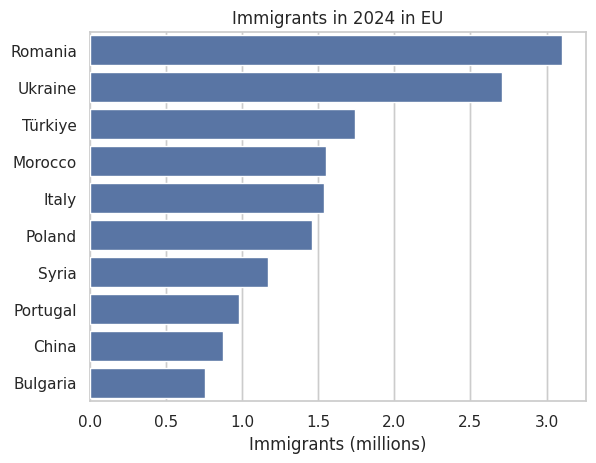

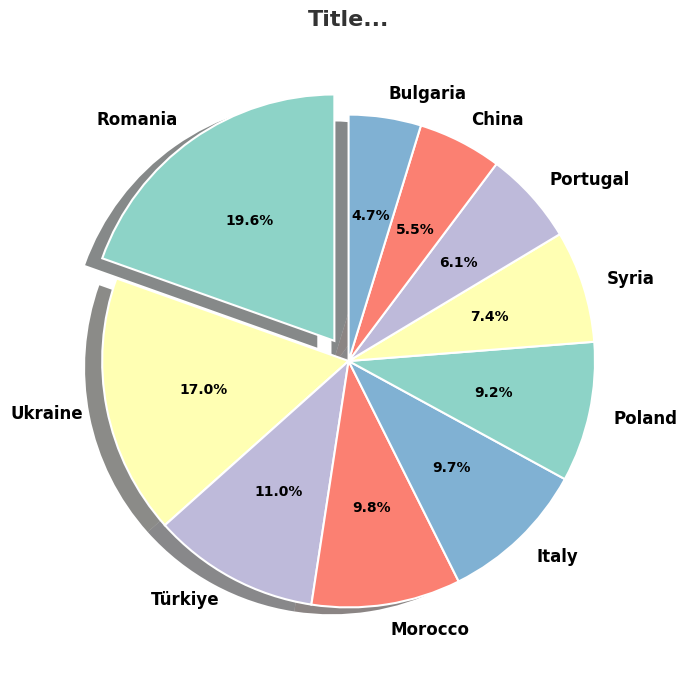

In [ ]:
#хто саме іммугрує з яких країн
url3 = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/total_reporty.csv"
data_full_immigration_by_citizen = pd.read_csv(url3, usecols=['Country of citizenship', 'sex','Geopolitical entity (reporting)', 'TIME_PERIOD', 'OBS_VALUE']).query("TIME_PERIOD == 2024")

#кількість іммігрантів у 2024 , та без внутрішної імміграції
data_full_immigration_by_citizen = (data_full_immigration_by_citizen.groupby(['Country of citizenship','Geopolitical entity (reporting)'])['OBS_VALUE']
                                    .sum()
                                    .sort_values(ascending=False)
                                    .reset_index())

data_full_immigration_by_citizen = data_full_immigration_by_citizen[data_full_immigration_by_citizen['Country of citizenship'] != data_full_immigration_by_citizen['Geopolitical entity (reporting)']]
data_full_immigration_by_citizen = data_full_immigration_by_citizen.sort_values(ascending=False,by='OBS_VALUE')

display(data_full_immigration_by_citizen)
### data_full_immigration_by_citizen це датасет получаться з іммігрантами які проживають у країні яка репортить у 2024 році.

data_full_by_citizen = data_full_immigration_by_citizen.groupby('Country of citizenship')['OBS_VALUE'].sum().sort_values(ascending=False)

### data_full_by_citizen цей датасет показує нам кількість усіх громадян певного громадянства у ЄС , які прожвивють не у своїй країні
pre_bar_plot = data_full_by_citizen.head(10)/ 1000000

sns.barplot(pre_bar_plot, orient='h', zorder=3)
plt.xlabel('Immigrants (millions)')
plt.ylabel('')
plt.title('Immigrants in 2024 in EU')
for i in range(5, 35, 5):
  plt.axvline(x=i/10, color='lightgray', linewidth=1, zorder=0)

fig, ax = plt.subplots(figsize=(8, 8))

explodes = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3']

wedges, texts, autotexts = ax.pie(
    pre_bar_plot,
    labels=pre_bar_plot.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=explodes,
    colors=colors,
    shadow={'ox': -0.05, 'edgecolor': 'none', 'shade': 0.9},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 12, 'color': 'black', 'weight': 'bold'},
)

for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

ax.set_title("Title...", fontsize=16, weight='bold', pad=20, color='#333333')




pass


['Türkiye', 'Ukraine', 'Syria', 'Romania', 'Poland']

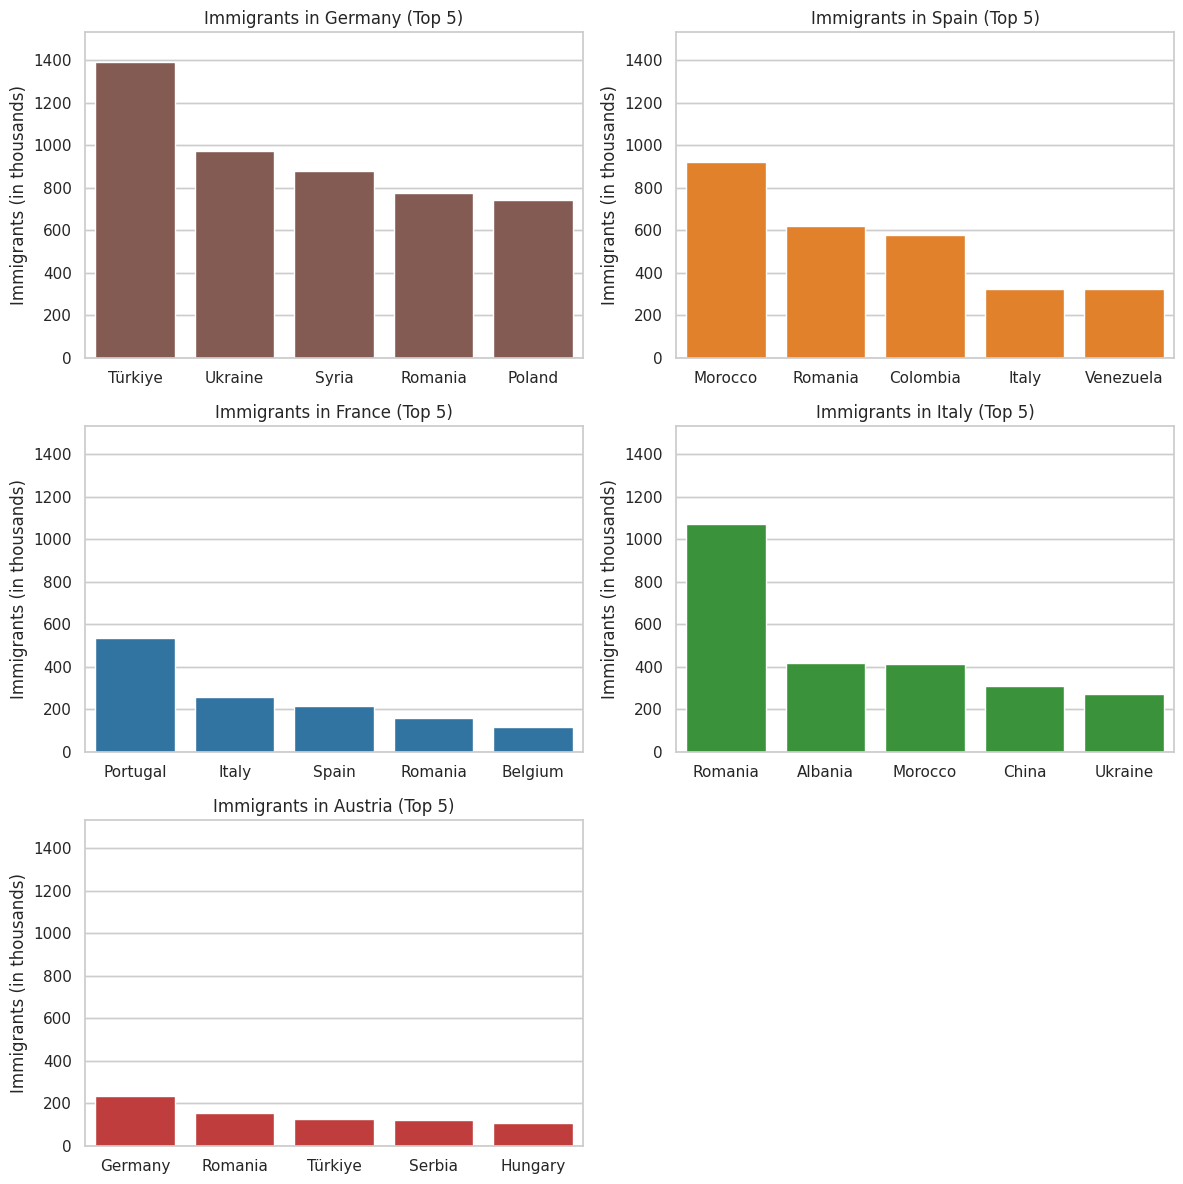

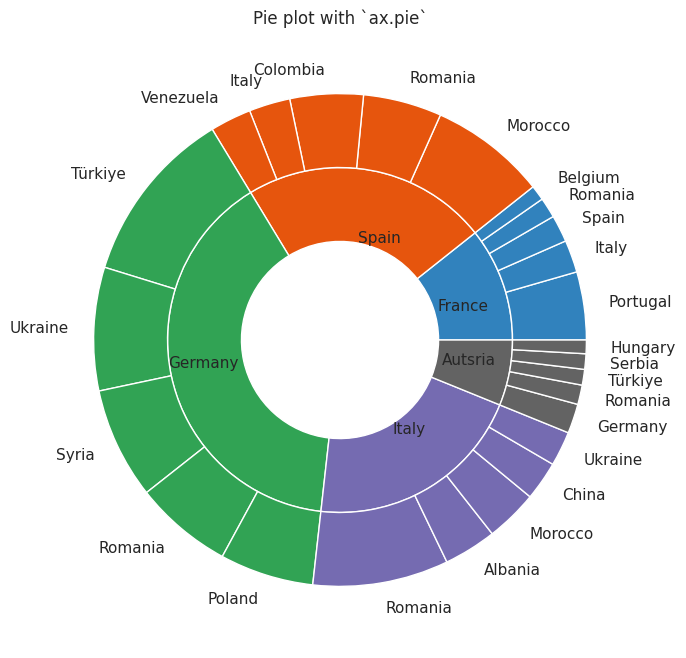

In [ ]:
data_full_immigration_by_Germany =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Germany'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_Italii = data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Italy'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_Austria =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Austria'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_Spain =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='Spain'].sort_values(by='OBS_VALUE',ascending=False)
data_full_immigration_by_French =data_full_immigration_by_citizen[data_full_immigration_by_citizen['Geopolitical entity (reporting)']=='France'].sort_values(by='OBS_VALUE',ascending=False)

data_full_immigration_by_Germany['OBS_VALUE'] = data_full_immigration_by_Germany['OBS_VALUE'] / 1_000
data_full_immigration_by_Italii['OBS_VALUE'] = data_full_immigration_by_Italii['OBS_VALUE'] / 1_000
data_full_immigration_by_Austria['OBS_VALUE'] = data_full_immigration_by_Austria['OBS_VALUE'] / 1_000
data_full_immigration_by_Spain['OBS_VALUE'] = data_full_immigration_by_Spain['OBS_VALUE'] / 1_000
data_full_immigration_by_French['OBS_VALUE'] = data_full_immigration_by_French['OBS_VALUE'] / 1_000

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 рядки, 2 стовпці підграфіків


max_y = 0
for country in [data_full_immigration_by_Germany, data_full_immigration_by_Spain, data_full_immigration_by_French, data_full_immigration_by_Italii, data_full_immigration_by_Austria]:
    value = country.iloc[0]['OBS_VALUE']
    if value > max_y:
        max_y = value



# Germany
sns.barplot(data=data_full_immigration_by_Germany.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[0, 0], color='#8c564b')
axes[0, 0].set_title('Immigrants in Germany (Top 5)')
axes[0, 0].set_ylabel('Immigrants (in thousands)')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[0, 0].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
# Spain
sns.barplot(data=data_full_immigration_by_Spain.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[0, 1], color='#ff7f0e')
axes[0, 1].set_title('Immigrants in Spain (Top 5)')
axes[0, 1].set_ylabel('Immigrants (in thousands)')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[0, 1].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
# France
sns.barplot(data=data_full_immigration_by_French.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[1, 0], color='#1f77b4')
axes[1, 0].set_title('Immigrants in France (Top 5)')
axes[1, 0].set_ylabel('Immigrants (in thousands)')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[1, 0].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
fig.delaxes(axes[2, 1])
# Italy
sns.barplot(data=data_full_immigration_by_Italii.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[1, 1], color='#2ca02c')
axes[1, 1].set_title('Immigrants in Italy (Top 5)')
axes[1, 1].set_ylabel('Immigrants (in thousands)')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[1, 1].axhline(y=y, color='lightgray', linewidth=1, zorder=0)
# Austria
sns.barplot(data=data_full_immigration_by_Austria.head(5), x='Country of citizenship', y='OBS_VALUE', ax=axes[2, 0], color='#d62728')
axes[2, 0].set_title('Immigrants in Austria (Top 5)')
axes[2, 0].set_ylabel('Immigrants (in thousands)')
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylim(0, max_y*1.1)
for y in np.arange(0, max_y*1.1, 200):
    axes[2, 0].axhline(y=y, color='lightgray', linewidth=1, zorder=0)


plt.tight_layout()

###Yarik robit
display()
pie_plot_data_Germany = list(data_full_immigration_by_Germany['OBS_VALUE'])[:5]
pie_plot_data_Spain = list(data_full_immigration_by_Spain['OBS_VALUE'])[:5]
pie_plot_data_France = list(data_full_immigration_by_French['OBS_VALUE'])[:5]
pie_plot_data_Italy = list(data_full_immigration_by_Italii['OBS_VALUE'])[:5]
pie_plot_data_Austria = list(data_full_immigration_by_Austria['OBS_VALUE'])[:5]

fig, ax = plt.subplots(figsize=(8, 8))

size = 0.3
vals = np.array([pie_plot_data_France, pie_plot_data_Spain,
 pie_plot_data_Germany, pie_plot_data_Italy, pie_plot_data_Austria])

tab20c = plt.color_sequences["tab20c"]
cmap = plt.get_cmap("tab20c")
group_colors = [cmap(i * 4) for i in range(len(vals))]
inner_colors = group_colors
outer_colors = []
for i in range(len(vals)):
    outer_colors.extend([group_colors[i]] * len(vals[i]))
inner_labels = ['France', 'Spain', 'Germany', 'Italy', 'Autsria']###countries_highest_number_immigrates
display(list(data_full_immigration_by_Germany['Country of citizenship'])[:5])
outer_labels = (
    list(data_full_immigration_by_French['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Spain['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Germany['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Italii['Country of citizenship'])[:5] +
    list(data_full_immigration_by_Austria['Country of citizenship'])[:5]
)

ax.pie(vals.sum(axis=1), radius=1-size, colors = inner_colors,
       labels=inner_labels,
       labeldistance=0.6,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1, colors = outer_colors,
       labels=outer_labels,
       #autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

###

plt.show()

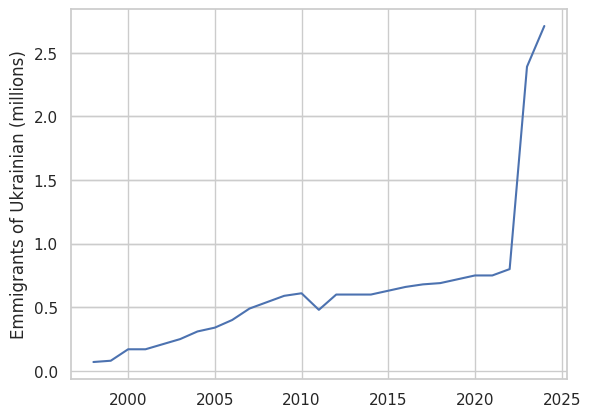

In [ ]:
##Ukraine
url_ua = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/Ukraine.csv"
Ukraine = pd.read_csv(url_ua,usecols = ['Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE', 'age', 'sex']).query('age == "TOTAL"').query('sex == "T"').drop(['age', 'sex'], axis=1)
Ukraine_by_time = Ukraine.groupby('TIME_PERIOD')['OBS_VALUE'].sum()
Ukraine_by_time = Ukraine_by_time.reset_index()
Ukraine_by_time['OBS_VALUE'] = Ukraine_by_time['OBS_VALUE'] / 1000000
Ukraine_by_time['OBS_VALUE'] = Ukraine_by_time['OBS_VALUE'].round(2)
sns.lineplot(data=Ukraine_by_time,x='TIME_PERIOD',y='OBS_VALUE')
plt.title("")
plt.ylabel("Emmigrants of Ukrainian (millions)")
plt.xlabel("")
for i in range(5, 30, 5):
    plt.axhline(y=i/10, color='lightgray', linewidth=1, zorder=0)
plt.show()

In [ ]:
# Slovakia
urls = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/PreSLovak_neighborhood.csv"
Slovak_and_iny = pd.read_csv(urls,usecols=['citizen','Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE'])
Slovak_and_iny = Slovak_and_iny.query("`Geopolitical entity (reporting)` in ['Slovakia', 'Hungary', 'Poland', 'Austria']")
Slovak_and_iny['OBS_VALUE'] = Slovak_and_iny['OBS_VALUE'] / 1000000
fig, axi = plt.subplots(figsize=(10, 6))

sns.lineplot(data=Slovak_and_iny, x='TIME_PERIOD', y='OBS_VALUE', marker='o',hue='Geopolitical entity (reporting)', linewidth=2.5)

plt.title('', fontsize=16)
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()
pass

In [ ]:
urls_SL = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/Slovaki_ds.csv"
Slovakian = pd.read_csv(urls_SL,usecols=['citizen','Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE'])
# 2019 бо у Великобританії 2019 уйшла а там є найбільше словаків топ 1-2 по кількості , але з 2017-2018 почао падати жоско а з 2020 уже логічо даних немає
years_of_interest = [2019,2024]
Slovakian1= Slovakian[Slovakian['TIME_PERIOD'].isin(years_of_interest)]
#Slovakian_avg_5 = Slovakian1.groupby('Geopolitical entity (reporting)', as_index=False)['OBS_VALUE']
#Slovakian_avg_5 = Slovakian_avg_5.rename(columns={'OBS_VALUE': '6_year_avg'})
#Slovakian_avg_5['6_year_avg'] = Slovakian_avg_5['6_year_avg'].round(0).astype(int)
Slovakian1 = Slovakian1.sort_values(by='OBS_VALUE', ascending=False)
poland_data = Slovakian1[Slovakian1['Geopolitical entity (reporting)'] == 'Poland']
# Топ-10 країн
top_10 = Slovakian1.query("TIME_PERIOD == 2019").head(10)

top_10 = top_10.sort_values(by='OBS_VALUE', ascending=False)
neighbors = ['Poland', 'Czechia', 'Austria', 'Hungary']
top_10['group'] = Slovakian1['Geopolitical entity (reporting)'].apply(lambda x: 'Neighbor' if x in neighbors else 'Non-neighbor')
axa = sns.barplot(data=top_10
, y='Geopolitical entity (reporting)', x='OBS_VALUE',hue='group')
for bar in axa.patches:
  width = bar.get_width()
  if width != 0:
    axa.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}', va='center', ha='left', fontsize=10, color='black')

axa.set_title('2019 Amount of Slovaks')
axa.set_xlabel("")
axa.set_ylabel("")

In [ ]:
data_2024 = Slovakian[Slovakian['TIME_PERIOD'] == 2024]
data_2024 = data_2024.sort_values(by='OBS_VALUE', ascending=False)

poland_data_2024 = data_2024[data_2024['Geopolitical entity (reporting)'] == 'Poland']

top_10_2024 = data_2024.head(10)
top_10_2024 = top_10_2024.sort_values(by='OBS_VALUE', ascending=False)
neighbors = ['Poland', 'Czechia', 'Austria', 'Hungary']
top_10_2024['group'] = top_10_2024['Geopolitical entity (reporting)'].apply(lambda x: 'Neighbor' if x in neighbors else 'Non-neighbor')
axa = sns.barplot(data=top_10_2024, y='Geopolitical entity (reporting)', x='OBS_VALUE', hue='group')
for bar in axa.patches:
    width = bar.get_width()
    if width != 0:
        axa.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                 f'{width:.1f}', va='center', ha='left', fontsize=10, color='black')

axa.set_title('2024 Amount of Slovaks')
axa.set_xlabel("")
axa.set_ylabel("")

In [ ]:
rls_SL_migrants = "https://raw.githubusercontent.com/loveBeatles/datavis_project/main/data/Migrants_in_Slovak.csv"
Slovakian_migrants = pd.read_csv(rls_SL_migrants,usecols=['Country of citizenship','Geopolitical entity (reporting)','TIME_PERIOD','OBS_VALUE'])
Slovakian_migrants_2024 = Slovakian_migrants.query('TIME_PERIOD == 2024')
Slovakian_migrants_2024 = Slovakian_migrants_2024.sort_values(by='OBS_VALUE',ascending=False)
Slovakian_migrants_2024
dada = sns.barplot(data=Slovakian_migrants_2024.head(10),y='Country of citizenship',x='OBS_VALUE')
for bar in dada.patches:
    width = bar.get_width()
    if width != 0:
        dada.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
                 f'{width:.1f}', va='center', ha='left', fontsize=10, color='black')
dada.set_title('')
dada.set_xlabel("")
dada.set_ylabel("")

### Part 2

#### Data loading

In [ ]:
### --- DATA LOADING --- ###
emigration_whole_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/emigration_whole.csv"
emigration_filtered_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/emigration_filtered.csv"

immigration_whole_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/immigration_whole.csv"
immigration_filtered_url = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/immigration_filtered.csv"

ua_displacement = "https://raw.githubusercontent.com/loveBeatles/datavis_project/refs/heads/main/data/ua_displacement.csv"

# -------------------------------------------------------------------------------------------------------------------------------------

emigration_whole = pd.read_csv(emigration_whole_url)
emigration_filtered = pd.read_csv(emigration_filtered_url)

immigration_whole = pd.read_csv(immigration_whole_url)
immigration_filtered = pd.read_csv(immigration_filtered_url)

asylum_eurostat = pd.read_csv("data/asylum_eurostat.csv")
ua_displacement = pd.read_csv(ua_displacement)

**About the data:**

- `emigration_whole` includes a comprehensive dataset from Eurostat with the code `migr_emi1ctz`. It contains information about sex, age categories, and citizenship, spanning the years 1998-2023.
- `immigration_whole` mirrors the structure of `emigration_whole` but focuses on immigrants. The corresponding Eurostat code is `migr_imm1ctz`.
- `emigration_filtered` is a subset of `emigration_whole`, filtered for EU countries starting from 2012. It includes data for total citizenship, age, and sex.
- `immigration_filtered` is the filtered counterpart of `immigration_whole`, containing similar data for immigrants.
- `asylum_eurostat` provides quarterly data (Q1-Q4) from 2008 to 2024. It includes details about sex, age categories, and citizenship.
- `ua_displacement` contains information about Ukrainian asylum-seekers, refugees, returned refugees from 2000 to 2024 year.

#### Data cleaning

In [ ]:
### --- DATA CLEANING --- ###
def clean_migration_data(df):
    """
    Cleans Eurostat migration data by converting it from wide to long format,
    filtering relevant rows, and handling missing values.
    """
    # Rename columns for clarity
    df = df.rename(columns={'geo\\TIME_PERIOD': 'country'})

    # Identify year columns (numeric column names)
    year_columns = [col for col in df.columns if col.isdigit()]

    # Convert from wide to long format
    long_df = pd.melt(
        df,
        id_vars=['country', 'citizen', 'age', 'sex'],
        value_vars=year_columns,
        var_name='year',
        value_name='count'
    )

    # Filter for relevant rows (TOTAL age, TOTAL sex, TOTAL citizen)
    long_df = long_df[
        (long_df['age'] == 'TOTAL') &
        (long_df['sex'] == 'T') &
        (long_df['citizen'] == 'TOTAL')
    ]

    # Convert year to integer and handle missing values in the value column
    long_df['year'] = long_df['year'].astype(int)
    long_df['count'] = pd.to_numeric(
        long_df['count'].replace(':', pd.NA),  # Replace ':' with NaN
        errors='coerce'
    ).fillna(0)  # Fill NaN with 0 for better handling in analysis

    # Drop unnecessary columns to reduce memory usage
    long_df = long_df.drop(columns=['age', 'sex', 'citizen'])

    # Reset index for a clean DataFrame
    long_df = long_df.reset_index(drop=True)
    long_df = long_df.drop_duplicates(subset=['country', 'year', 'count'], keep='first')

    return long_df

In [ ]:
def clean_asylum_data(df):
    """
    Cleans Eurostat asylum data by filtering relevant rows,
    converting from wide to long format,
    """
    # Filter relevant dimensions
    df = df[
        (df['age'] == 'TOTAL') &
        (df['sex'] == 'T') &
        (df['decision'] == 'TOTAL') &
        (~df[r'geo\TIME_PERIOD'].isin(['EU27_2020', 'EU28']))
    ].copy()

    # Identify time columns using regex
    time_columns = [col for col in df.columns if re.match(r'\d{4}-Q[1-4]', col)]

    # Convert from wide to long format
    id_vars = [col for col in df.columns if col not in time_columns]
    df = df.melt(
        id_vars=id_vars,
        var_name='period',
        value_name='asylum_seekers'
    )

    # Extract year and quarter from period
    df[['year', 'quarter']] = df['period'].str.extract(r'(\d{4})-Q(\d)')
    df = df.dropna(subset=['year', 'quarter'])
    df['year'] = df['year'].astype(int)
    df['quarter'] = df['quarter'].astype(int)

    # Convert to datetime (first day of quarter)
    df['date'] = pd.to_datetime(
        df['year'].astype(str) + '-' + (3*df['quarter']-2).astype(str) + '-01'
    )

    # Clean numerical values
    df['asylum_seekers'] = (
        pd.to_numeric(df['asylum_seekers'], errors='coerce')
        .fillna(0)
        .astype(int)
    )

    # Filter time range
    df = df[df['year'].between(2013, 2023)]

    # Country mapping
    country_mapping = {
        'BE': 'Belgium',
        'FR': 'France',
        'LU': 'Luxembourg',
        'NL': 'Netherlands',
        'DE': 'Germany',
        'DK': 'Denmark',
        'IE': 'Ireland',
        'SE': 'Sweden',
        'FI': 'Finland',
        'ES': 'Spain',
        'PT': 'Portugal',
        'IT': 'Italy',
        'MT': 'Malta',
        'EL': 'Greece',
        'CY': 'Cyprus',
        'PL': 'Poland',
        'CZ': 'Czechia',
        'SK': 'Slovakia',
        'HU': 'Hungary',
        'SI': 'Slovenia',
        'HR': 'Croatia',
        'RO': 'Romania',
        'BG': 'Bulgaria',
        'EE': 'Estonia',
        'LV': 'Latvia',
        'LT': 'Lithuania',
        'AT': 'Austria'
    }

    df['country'] = df[r'geo\TIME_PERIOD'].map(country_mapping).fillna('Other')

    # Aggregate to country-year level
    agg_df = df.groupby(['country', 'year'], as_index=False).agg(
        total_asylum_seekers=('asylum_seekers', 'sum'),
        avg_quarterly=('asylum_seekers', 'mean'),
        q25=('asylum_seekers', lambda x: np.quantile(x, 0.25)),
        median=('asylum_seekers', 'median'),
        q75=('asylum_seekers', lambda x: np.quantile(x, 0.75))
    )

    return agg_df

In [ ]:
emigration_whole_cleaned = clean_migration_data(emigration_whole)
immigration_whole_cleaned = clean_migration_data(immigration_whole)
asylum_eurostat_cleaned = clean_asylum_data(asylum_eurostat)

In [ ]:
### --- DATA MERGE --- ###
migration_data = pd.merge(
    immigration_whole_cleaned.rename(columns={'count': 'immigrants'}),
    emigration_whole_cleaned.rename(columns={'count': 'emigrants'}),
    on=['country', 'year'],
    how='outer'
)

# Filter for target countries
target_countries = ['SK', 'AT', 'HU', 'CZ', 'PL']  # Slovakia, Austria, Hungary, Czechia, Poland
migration_data_sk_neighbors = migration_data[migration_data['country'].isin(target_countries)]


In [ ]:
display(emigration_whole_cleaned.sample(10))

,country,year,count
343,MD,2002,0.0
1999,UZ,2022,0.0
1778,IT,2020,159884.0
3,CH,1998,94778.0
2031,SE,2023,73434.0
1131,EU27_2020,2012,0.0
262,LV,2001,24539.0
2079,UZ,2023,0.0
970,ES,2010,403377.0
1556,AM,2017,0.0


In [ ]:
display(immigration_whole_cleaned.sample(10))

,country,year,count
1236,DE,2013,692713.0
1989,LU,2022,31433.0
163,UZ,1999,0.0
1919,SI,2021,23624.0
1996,NO,2022,90475.0
1497,LU,2016,22888.0
1003,LI,2010,591.0
14,HR,1998,51784.0
930,NO,2009,55953.0
905,CH,2009,160623.0


In [ ]:
display(asylum_eurostat_cleaned.sample(10))

,country,year,total_asylum_seekers,avg_quarterly,q25,median,q75
256,Romania,2016,3800,4.611650,0.0,0.0,0.0
260,Romania,2020,7445,9.035194,0.0,0.0,0.0
84,Estonia,2020,195,0.236650,0.0,0.0,0.0
266,Slovakia,2015,360,0.436893,0.0,0.0,0.0
85,Estonia,2021,205,0.248786,0.0,0.0,0.0
71,Denmark,2018,7840,9.514563,0.0,0.0,0.0
180,Lithuania,2017,1095,1.328883,0.0,0.0,0.0
175,Latvia,2023,770,0.934466,0.0,0.0,0.0
92,Finland,2017,21480,26.067961,0.0,0.0,0.0
276,Slovenia,2014,250,0.303398,0.0,0.0,0.0


In [ ]:
display(migration_data.sample(10))

,country,year,immigrants,emigrants
967,RO,2007,0.0,0.0
175,BY,2017,0.0,0.0
218,CY,2008,21060.0,4474.0
1101,SM,2011,0.0,0.0
686,LU,2008,17758.0,10058.0
1064,SK,2000,2274.0,811.0
586,IT,2012,350772.0,106216.0
1115,TJ,1999,0.0,0.0
567,IS,2019,9872.0,4590.0
723,LV,2019,11223.0,14583.0


In [ ]:
display(migration_data_sk_neighbors.sample(10))

,country,year,immigrants,emigrants
32,AT,2004,122547.0,71721.0
512,HU,2016,53618.0,39889.0
243,CZ,2007,104445.0,20500.0
507,HU,2011,28018.0,15100.0
237,CZ,2001,12918.0,21469.0
919,PL,2011,157059.0,265798.0
506,HU,2010,25519.0,13365.0
48,AT,2020,103565.0,62581.0
255,CZ,2019,105888.0,77798.0
1082,SK,2018,7253.0,3298.0


#### Visualization

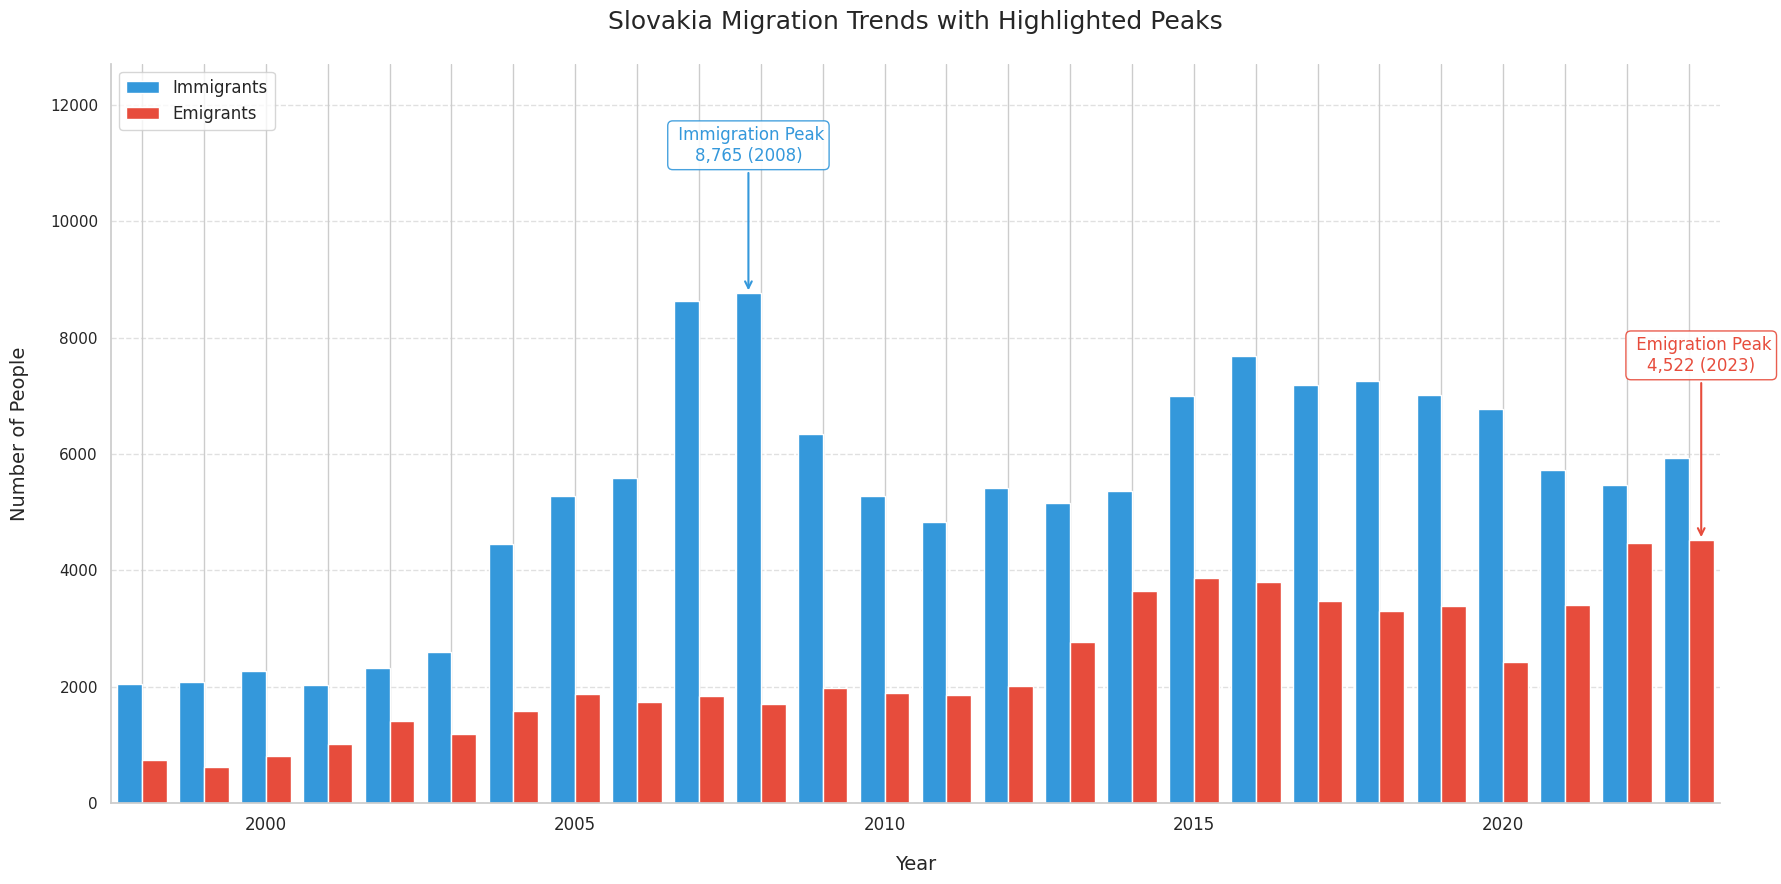

In [ ]:
### --- Slovakia Migration Plot --- ###
def plot_slovakia_migration(data):
    """Migration plot"""

    # Load and prepare data
    sk_data = data[data['country'] == 'SK'].copy()

    sk_data['year'] = sk_data['year'].astype(int)
    sk_data = sk_data.sort_values('year').reset_index(drop=True)

    # Create figure
    fig = plt.figure(figsize=(18, 9))
    ax = plt.gca()

    # Visual parameters
    bar_width = 0.4
    years = sk_data['year'].astype(int)
    x_pos = np.arange(len(years))
    color_imm = '#3498db'
    color_emi = '#e74c3c'

    # Plot bars
    ax.bar(x_pos - bar_width/2, sk_data['immigrants'], bar_width,
          label='Immigrants', color=color_imm, edgecolor='white')
    ax.bar(x_pos + bar_width/2, sk_data['emigrants'], bar_width,
          label='Emigrants', color=color_emi, edgecolor='white')

    # Configure x-axis (5-year intervals)
    xtick_labels = [str(y) if y%5 == 0 else '' for y in years]
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xtick_labels, fontsize=12)

    # Find peak values
    max_imm = sk_data['immigrants'].max()
    max_imm_year = sk_data.loc[sk_data['immigrants'].idxmax(), 'year']
    max_emi = sk_data['emigrants'].max()
    max_emi_year = sk_data.loc[sk_data['emigrants'].idxmax(), 'year']

    # Calculate positions
    imm_idx = sk_data['immigrants'].idxmax()
    emi_idx = sk_data['emigrants'].idxmax()
    imm_x = x_pos[imm_idx] - bar_width/2
    emi_x = x_pos[emi_idx] + bar_width/2

    # Vertical spacing parameters
    y_gap = max(max_imm, max_emi) * 0.18  # 18% of max value

    # Immigration annotation
    ax.annotate(f' Immigration Peak\n{int(max_imm):,} ({max_imm_year})',
                xy=(imm_x, max_imm),
                xytext=(imm_x, max_imm + y_gap*1.4),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color_imm,
                                connectionstyle='angle3,angleA=0,angleB=90'),
                ha='center', va='bottom', fontsize=12, color=color_imm,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color_imm, alpha=0.9))

    # Emigration annotation
    ax.annotate(f' Emigration Peak\n{int(max_emi):,} ({max_emi_year})',
                xy=(emi_x, max_emi),
                xytext=(emi_x, max_emi + y_gap*1.8),
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color_emi,
                                connectionstyle='angle3,angleA=0,angleB=90'),
                ha='center', va='bottom', fontsize=12, color=color_emi,
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=color_emi, alpha=0.9))

    # Formatting
    ax.set_title('Slovakia Migration Trends with Highlighted Peaks', fontsize=18, pad=25)
    ax.set_xlabel('Year', fontsize=14, labelpad=15)
    ax.set_ylabel('Number of People', fontsize=14, labelpad=15)
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.legend(frameon=True, fontsize=12, loc='upper left')

    # Set axis limits
    ax.set_ylim(top=max(max_imm, max_emi)*1.45)
    ax.set_xlim(-0.5, len(years)-0.5)

    # Remove spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Save figure
    fig_save(fig, 'img/slovakia_migration_trends.png')

plot_slovakia_migration(migration_data_sk_neighbors)

In [ ]:
display(migration_data_sk_neighbors.query('country == "CZ"'))

,country,year,immigrants,emigrants
234,CZ,1998,0.0,0.0
235,CZ,1999,0.0,0.0
236,CZ,2000,0.0,0.0
237,CZ,2001,12918.0,21469.0
238,CZ,2002,44679.0,32389.0
239,CZ,2003,60015.0,34226.0
240,CZ,2004,53453.0,34818.0
241,CZ,2005,60294.0,24065.0
242,CZ,2006,68183.0,33463.0
243,CZ,2007,104445.0,20500.0


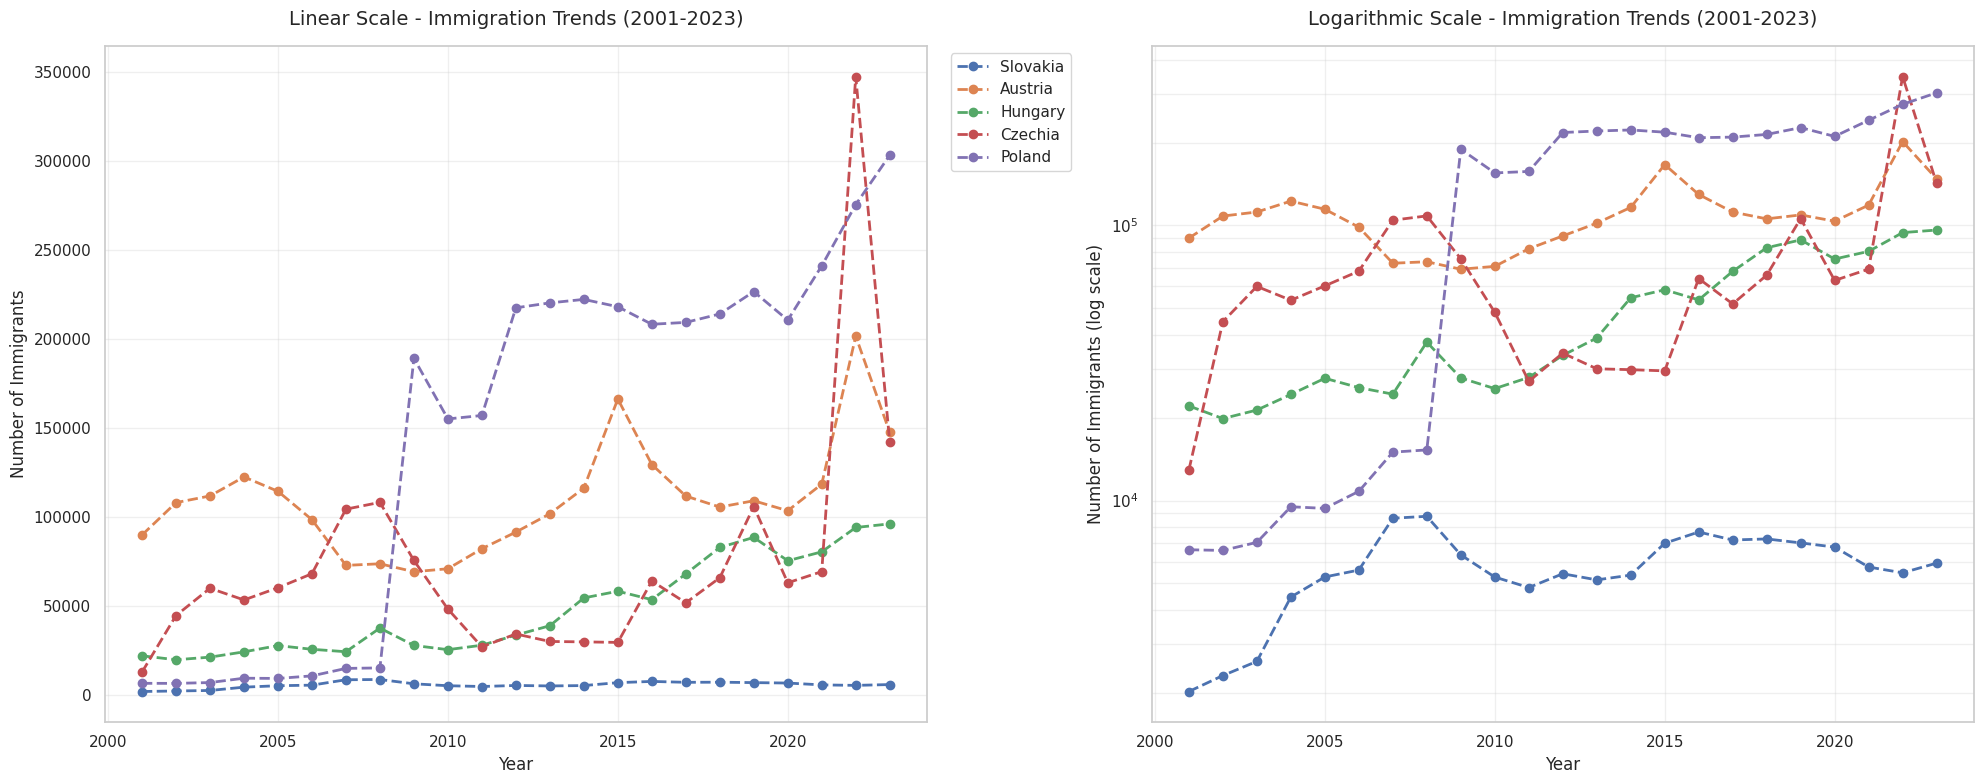

In [ ]:
### --- Neighboring Countries Comparison --- ###
def plot_neighbor_comparison(data):
    """Compare migration in neighboring countries with dual scaling"""

    # Display the data from 2000 year because of missing data in CZ in 1998, 1999, 2000
    data = data.query('year > 2000').copy()

    # Prepare data
    countries = {
        'SK': 'Slovakia',
        'AT': 'Austria',
        'HU': 'Hungary',
        'CZ': 'Czechia',
        'PL': 'Poland'
    }

    # Create dual plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Common styling parameters
    line_style = {'marker': 'o', 'linestyle': '--', 'linewidth': 2, 'markersize': 6}

    # Plot both versions
    for code, name in countries.items():
        country_data = data[data['country'] == code]

        # Linear scale plot
        ax1.plot(
            country_data['year'],
            country_data['immigrants'],
            label=f'{name}',
            **line_style
        )

        # Log scale plot
        ax2.plot(
            country_data['year'],
            country_data['immigrants'],
            label=f'{name}',
            **line_style
        )

    # Configure linear scale plot
    ax1.set_title('Linear Scale - Immigration Trends (2001-2023)', fontsize=14, pad=15)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Number of Immigrants', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Configure log scale plot
    ax2.set_title('Logarithmic Scale - Immigration Trends (2001-2023)', fontsize=14, pad=15)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Number of Immigrants (log scale)', fontsize=12)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, which='both')

    # Adjust layout and save
    plt.tight_layout()
    plt.show()

    # Save figure
    fig_save(fig, 'img/sk_neighbors_comparison_dual_scales.png')


plot_neighbor_comparison(migration_data_sk_neighbors)

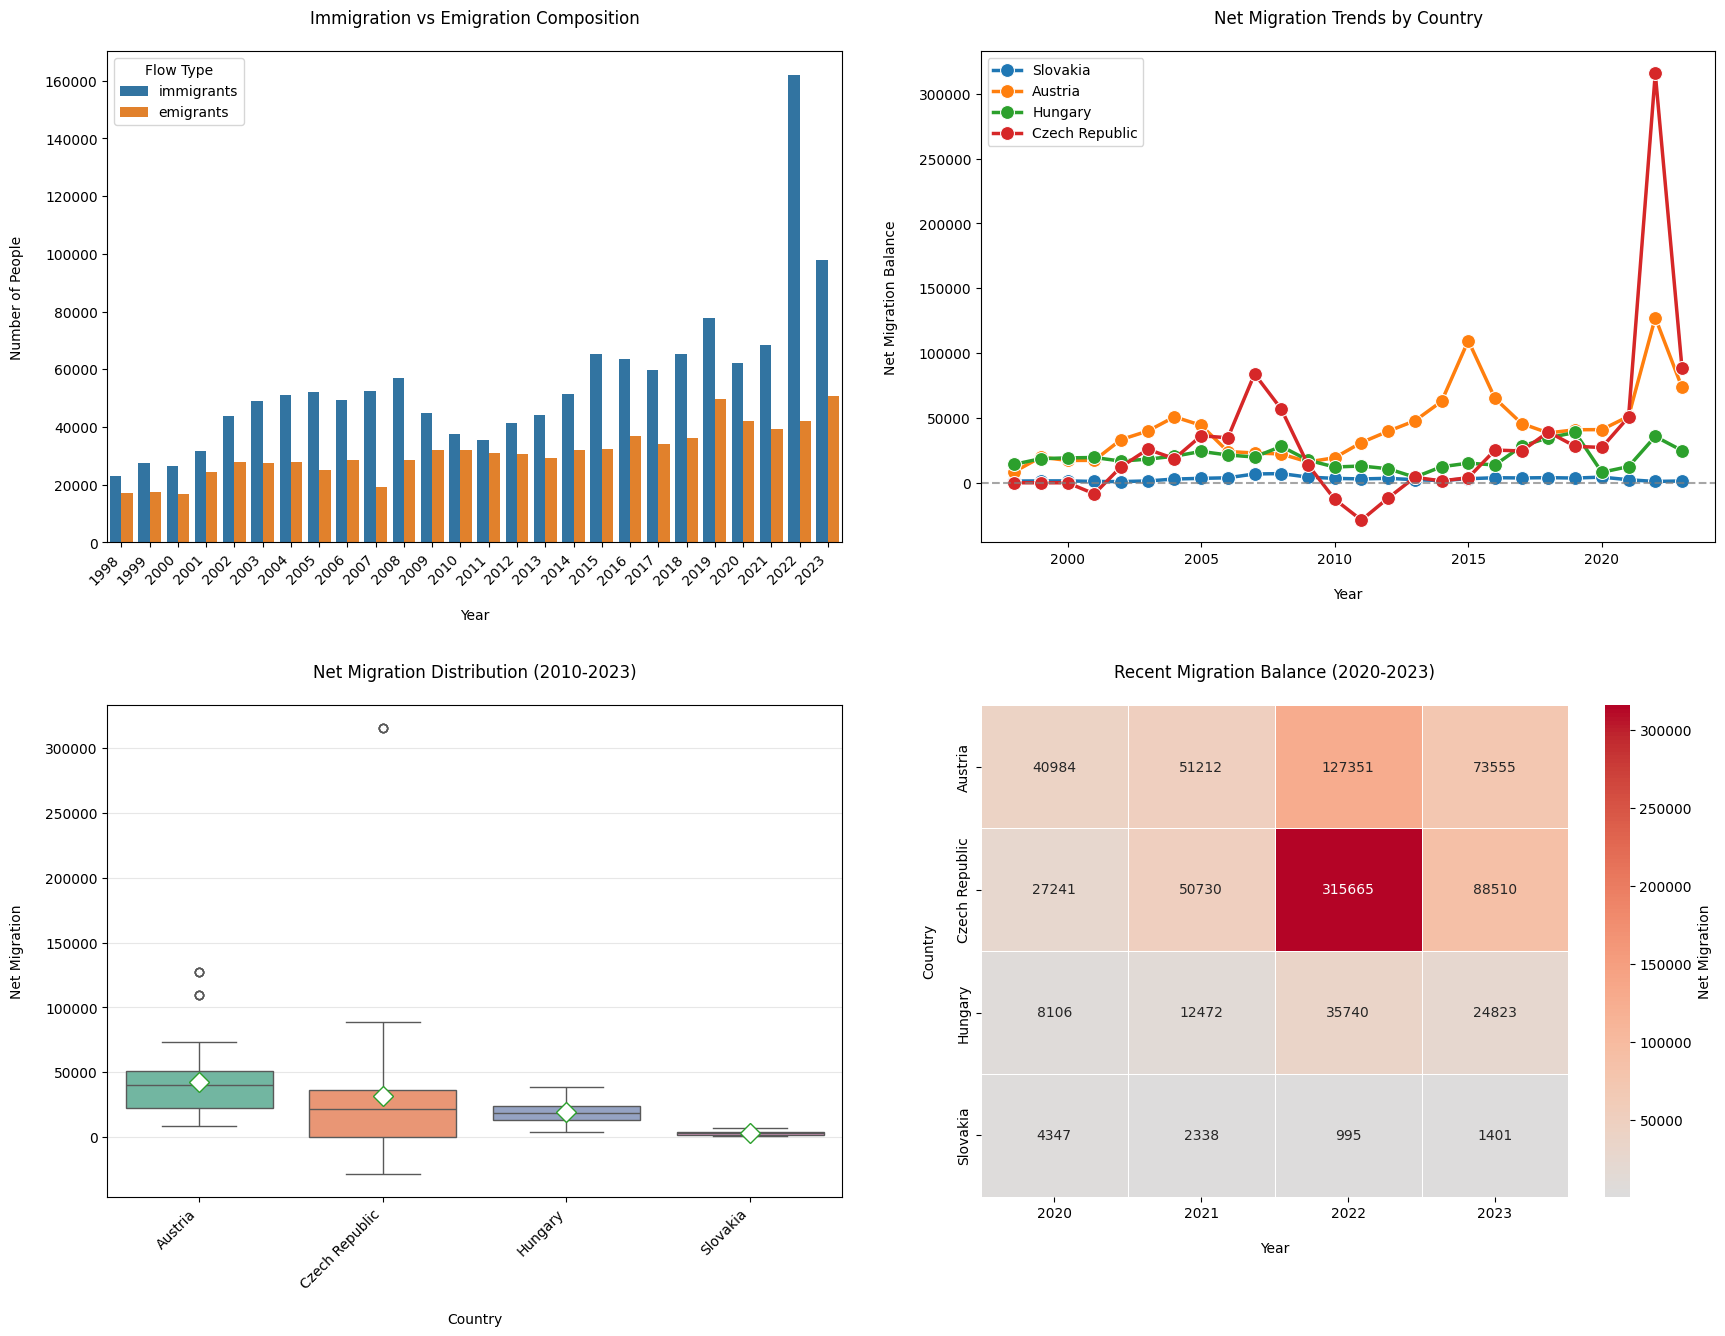

In [ ]:
def analyze_migration_trends(data):
    """
    Analyze migration patterns for target countries
    Produces 4-panel visualization using seaborn
    """
    # Country code to name mapping
    COUNTRY_NAMES = {
        'SK': 'Slovakia',
        'AT': 'Austria',
        'HU': 'Hungary',
        'CZ': 'Czech Republic'
    }

    # Prepare data
    df = data.copy().replace({'country': COUNTRY_NAMES})
    df['net_migration'] = df['immigrants'] - df['emigrants']
    recent_years = df[df['year'] >= 2020]

    # Create figure
    plt.figure(figsize=(18, 14))
    plt.style.context('ggplot')

    # --- Panel 1: Migration Composition ---
    plt.subplot(2, 2, 1)
    ax1 = sns.barplot(
    x='year',
    y='value',
    hue='type',
    data=df.melt(
        id_vars=['country', 'year'],
        value_vars=['immigrants', 'emigrants'],
        var_name='type'
    ),
    palette={'immigrants': '#1f77b4', 'emigrants': '#ff7f0e'},
    errorbar=None
    )
    plt.title('Immigration vs Emigration Composition', pad=20)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel('Number of People', labelpad=15)
    plt.legend(title='Flow Type', frameon=True)
    plt.xticks(rotation=45, ha='right')

    # Fix x-axis labels rotation
    plt.xticks(rotation=45, ha='right')

    # --- Panel 2: Net Migration Trends ---
    plt.subplot(2, 2, 2)
    for country in COUNTRY_NAMES.values():
        country_data = df[df['country'] == country]
        sns.lineplot(
            x='year',
            y='net_migration',
            data=country_data,
            label=country,
            marker='o',
            linewidth=2.5,
            markersize=10
        )
    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
    plt.title('Net Migration Trends by Country', pad=20)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel('Net Migration Balance', labelpad=15)
    plt.legend(frameon=True)

    # --- Panel 3: Country Comparison ---
    plt.subplot(2, 2, 3)
    ax3 = sns.boxplot(
        x='country',
        y='net_migration',
        hue='country',  # Added hue parameter
        data=df,
        palette='Set2',
        showmeans=True,
        meanprops={"marker":"D", "markerfacecolor":"white", "markersize":"10"},
        dodge=False,  # Disable dodge when using hue with same variable
        legend=False  # Disable redundant legend
    )
    plt.title('Net Migration Distribution (2010-2023)', pad=20)
    plt.xlabel('Country', labelpad=15)
    plt.ylabel('Net Migration', labelpad=15)
    plt.grid(axis='y', alpha=0.3)

    # Fix x-axis labels rotation
    plt.xticks(rotation=45, ha='right')

    # --- Panel 4: Recent Years Heatmap ---
    plt.subplot(2, 2, 4)
    heatmap_data = recent_years.pivot_table(
        index='country',
        columns='year',
        values='net_migration'
    )
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".0f",
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Net Migration'}
    )
    plt.title('Recent Migration Balance (2020-2023)', pad=20)
    plt.xlabel('Year', labelpad=15)
    plt.ylabel('Country', labelpad=15)

    plt.tight_layout(pad=3.0)
    plt.show()

# Run analysis
analyze_migration_trends(migration_data)

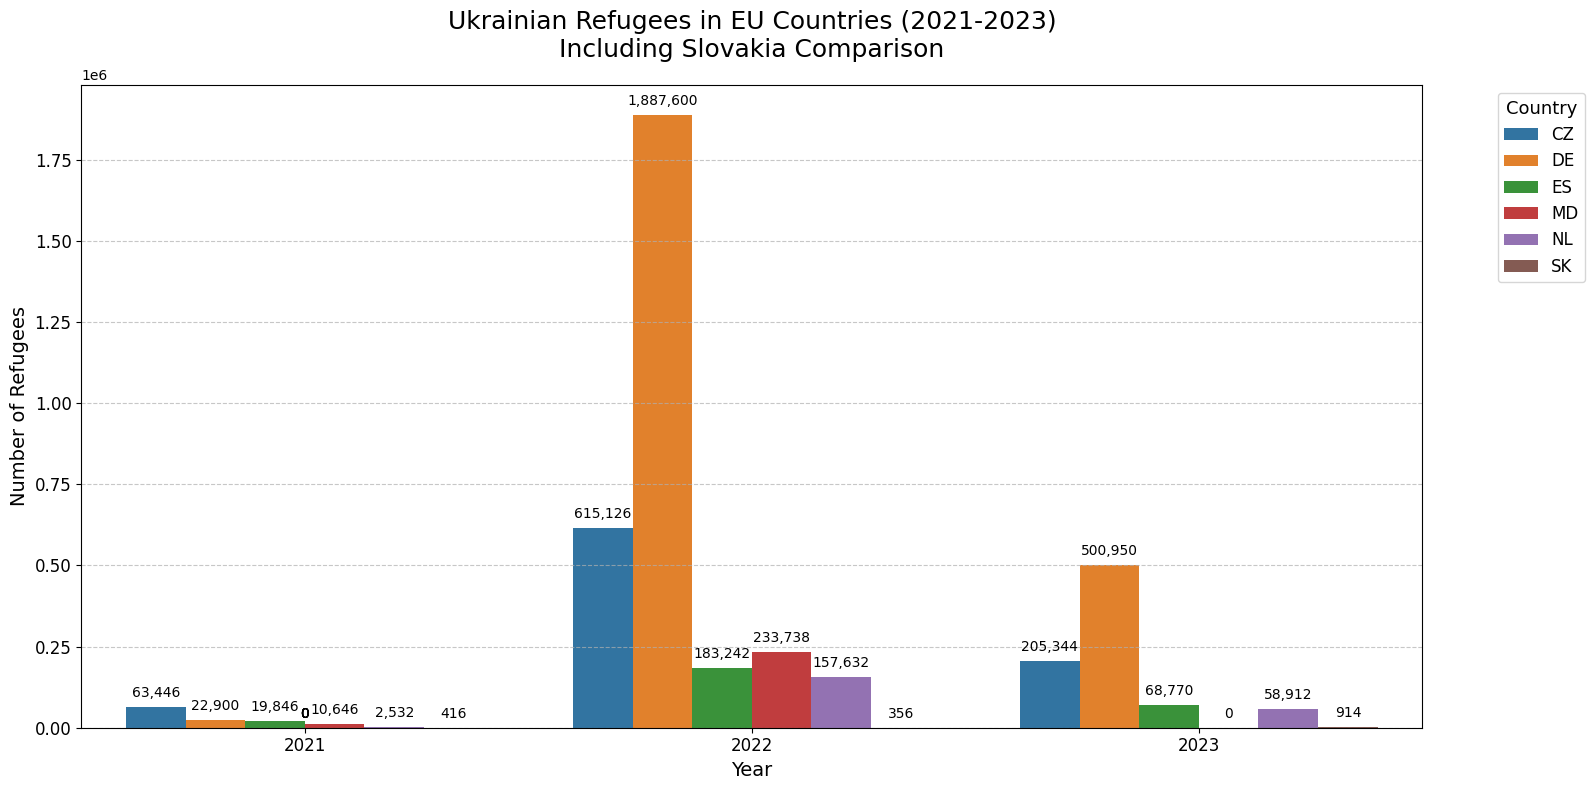

In [ ]:
### --- Ukraine War Impact Analysis --- ###
def plot_ukraine_impact():
    """
    Analyze Ukrainian refugee impact in EU countries (2021-2023)
    Includes Slovakia and top 5 receiving nations
    """

    # Load and filter data
    ukr_raw = pd.read_csv(immigration_whole_url)
    ukr_data = ukr_raw.rename(columns={'geo\\TIME_PERIOD': 'country'})

    # Melt to long format
    years = [col for col in ukr_data.columns if col.isdigit()]
    ukr_long = pd.melt(
        ukr_data,
        id_vars=['country', 'citizen', 'age', 'sex'],
        value_vars=years,
        var_name='year',
        value_name='count'
    )

    # Clean and filter data
    ukr_clean = ukr_long[
        (ukr_long['citizen'] == 'UA') &
        (ukr_long['year'].between('2021', '2023')) &
        (ukr_long['age'] == 'TOTAL') &
        (ukr_long['sex'] == 'T')
    ].copy()

    # Convert types and handle missing values
    ukr_clean['year'] = ukr_clean['year'].astype(int)
    ukr_clean['count'] = pd.to_numeric(
        ukr_clean['count'].replace(':', 0),
        errors='coerce'
    ).fillna(0)

    # Prepare top countries including Slovakia
    top_countries = ukr_clean.groupby('country')['count'].sum().nlargest(5).index
    if 'SK' not in top_countries:
        top_countries = list(top_countries) + ['SK']

    # Create visualization
    plt.figure(figsize=(16, 8))

    # Plot grouped bars
    sns.barplot(
        data=ukr_clean[ukr_clean['country'].isin(top_countries)],
        x='year',
        y='count',
        hue='country',
        palette='tab10',
        estimator=sum,
        errorbar=None
    )

    # Formatting
    plt.title('Ukrainian Refugees in EU Countries (2021-2023)\nIncluding Slovakia Comparison',
             fontsize=18, pad=20)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Refugees', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Country', fontsize=12, title_fontsize=13,
              bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add value labels
    for p in plt.gca().patches:
        plt.gca().annotate(
            f'{int(p.get_height()):,}',
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center', va='bottom', fontsize=10, xytext=(0, 5),
            textcoords='offset points'
        )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_ukraine_impact()

In [ ]:
### --- Ukraine War Impact Analysis --- ###
def plot_ukraine_refugees():
    """Analyze Ukrainian refugee impact in EU countries (2021-2023) with map"""
    # Load and prepare data
    df = pd.read_csv(immigration_whole_url)
    df = df.rename(columns={'geo\\TIME_PERIOD': 'country_code'})

    # Country code to name mapping
    country_map = {
        'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'CZ': 'Czechia',
        'DE': 'Germany', 'FR': 'France', 'HU': 'Hungary', 'IT': 'Italy',
        'PL': 'Poland', 'RO': 'Romania', 'SK': 'Slovakia', 'UA': 'Ukraine'
    }

    # Process data
    refugee_data = (
        pd.melt(df,
               id_vars=['country_code', 'citizen', 'age', 'sex'],
               value_vars=[col for col in df.columns if col.isdigit()],
               var_name='year',
               value_name='count')
        .query("citizen == 'UA' & year.between('2021', '2023')")
        .assign(
            year = lambda x: x['year'].astype(int),
            count = lambda x: pd.to_numeric(x['count'].replace(':', '0'), errors='coerce'),
            country = lambda x: x['country_code'].map(country_map)
        )
        .groupby(['country_code', 'country', 'year'])['count'].sum().reset_index()
    )

    # Get top countries including Slovakia
    top_countries = refugee_data.groupby('country_code')['count'].sum().nlargest(5).index
    if 'SK' not in top_countries:
        top_countries = list(top_countries) + ['SK']
    plot_data = refugee_data[refugee_data['country_code'].isin(top_countries)]

    # Create visualization
    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{"type": "choropleth"}], [{"type": "bar"}]],
        vertical_spacing=0.1,
        subplot_titles=("Refugee Distribution in Europe", "Yearly Comparison")
    )

    # Map plot
    fig.add_trace(
        go.Choropleth(
            locations=plot_data['country'],
            z=plot_data['count'],
            locationmode='country names',
            colorscale='Oranges',
            marker_line_color='gray',
            colorbar_title='Refugees',
            hoverinfo='location+z',
            name=''
        ),
        row=1, col=1
    )

    # Bar chart
    for country in plot_data['country'].unique():
        country_df = plot_data[plot_data['country'] == country]
        fig.add_trace(
            go.Bar(
                x=country_df['year'],
                y=country_df['count'],
                name=country,
                showlegend=False
            ),
            row=2, col=1
        )

    # Layout settings
    fig.update_layout(
        template='plotly_white',
        height=800,
        margin={"r":20,"t":40,"l":20,"b":20},
        hoverlabel=dict(font_size=14)
    )

    # Europe map configuration
    fig.update_geos(
        resolution=50,
        scope="europe",
        center={"lat": 50, "lon": 15},
        projection_scale=2.3,
        showcountries=True,
        countrycolor="lightgray",
        showcoastlines=True,
        coastlinecolor="gray",
        showocean=True,
        oceancolor="azure",
        showframe=False
    )

    # Bar chart formatting
    fig.update_xaxes(title_text="Year", row=2, col=1)
    fig.update_yaxes(title_text="Number of Refugees", row=2, col=1)

    # Highlight Slovakia
    fig.for_each_trace(
        lambda trace: trace.update(marker_color='#2ca02c') if trace.name == 'Slovakia' else (),
    )

    return fig

plot_ukraine_refugees().show()

In [ ]:
### --- Covid Impact --- ###
def plot_covid_impact(data):
    """
    Analyze COVID-19 impacts with proper log scale handling
    """
    # Prepare data
    analysis_years = range(2018, 2024)
    region_data = data.groupby('year')['immigrants'].mean().reset_index()
    slovakia_data = data[data['country'] == 'SK'][['year', 'immigrants']]

    # Handle zero values for log scale
    region_data['immigrants'] = region_data['immigrants'].replace(0, 1)
    slovakia_data['immigrants'] = slovakia_data['immigrants'].replace(0, 1)

    # Calculate percentage changes
    pre_covid_reg = region_data[region_data['year'].between(2018, 2019)]['immigrants'].mean()
    covid_reg = region_data[region_data['year'].between(2020, 2021)]['immigrants'].mean()
    reg_change = ((covid_reg - pre_covid_reg) / pre_covid_reg) * 100

    pre_covid_sk = slovakia_data[slovakia_data['year'].between(2018, 2019)]['immigrants'].mean()
    covid_sk = slovakia_data[slovakia_data['year'].between(2020, 2021)]['immigrants'].mean()
    sk_change = ((covid_sk - pre_covid_sk) / pre_covid_sk) * 100

    # Create plot
    plt.figure(figsize=(12, 6))

    # Set logarithmic scale with proper formatting
    plt.yscale('log')

    # Plot trends with distinct markers
    sns.lineplot(x='year', y='immigrants', data=region_data,
                color='#1f77b4', marker='o', markersize=8,
                linewidth=2, label='Regional Average')
    sns.lineplot(x='year', y='immigrants', data=slovakia_data,
                color='#2ca02c', marker='s', markersize=6,
                linewidth=2, label='Slovakia')

    # Event markers
    plt.axvspan(2020, 2021, color='gray', alpha=0.2, label='COVID-19 Period')
    plt.axvline(2022, color='red', linestyle='--', alpha=0.7, label='War Start')

    # External annotations
    plt.annotate(f'Regional: {reg_change:+.1f}%',
                xy=(2021, region_data[region_data['year'] == 2021]['immigrants'].values[0]),
                xytext=(2023.2, region_data['immigrants'].max()),
                ha='left', va='top',
                color='#1f77b4',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#1f77b4'),
                arrowprops=dict(arrowstyle='->', color='#1f77b4',
                              connectionstyle="arc3,rad=-0.2"))

    plt.annotate(f'Slovakia: {sk_change:+.1f}%',
                xy=(2021, slovakia_data[slovakia_data['year'] == 2021]['immigrants'].values[0]),
                xytext=(2023.2, slovakia_data['immigrants'].min()),
                ha='left', va='bottom',
                color='#2ca02c',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='#2ca02c'),
                arrowprops=dict(arrowstyle='->', color='#2ca02c',
                              connectionstyle="arc3,rad=0.2"))

    # Formatting
    plt.title('COVID-19 Impact Analysis (Log Scale)', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12, labelpad=10)
    plt.ylabel('Immigration Count', fontsize=12, labelpad=10)
    plt.xticks(analysis_years, rotation=45, fontsize=10)
    plt.xlim(2017.8, 2023.5)

    # Proper log scale formatting
    plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
    plt.gca().yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=5))
    plt.grid(alpha=0.3, which='both')
    plt.legend(frameon=True, loc='upper left')

    plt.tight_layout()
    plt.show()

plot_covid_impact(migration_data)